# Lecture 12: Simplifying Data — PCA and Friends

## Introduction

High-dimensional data is everywhere in machine learning: text embeddings with hundreds of dimensions, images with thousands of pixels, genomic data with tens of thousands of features. But humans can only visualize 2D or 3D spaces. How do we explore and understand high-dimensional structure?

This notebook introduces **dimensionality reduction (DR)** techniques that compress high-dimensional data while preserving important relationships. We'll start with **Principal Component Analysis (PCA)**, the foundational linear method, then explore modern nonlinear techniques like **t-SNE**, **UMAP**, and **PaCMAP**. Finally, we'll apply these methods to a real challenge: distinguishing AI-generated text from human writing using embeddings.

## Learning Objectives

By the end of this notebook, you will be able to:

1. **Explain PCA geometrically**: Understand how PCA finds directions of maximum variance and what this means for data compression
2. **Recognize PCA's limitations**: Know when PCA works well (linear structure, global relationships) and when it fails (nonlinear manifolds, local clusters)
3. **Choose appropriate DR methods**: Select between PCA, t-SNE, UMAP, and PaCMAP based on whether you need local structure, global structure, or both
4. **Interpret DR visualizations**: Read 2D projections critically, understanding what relationships are preserved and what might be artifacts
5. **Apply DR to real data**: Use the full pipeline (embedding → PCA → nonlinear DR → clustering) on text data while avoiding common pitfalls like text length leakage
6. **Optimize DR workflows**: Use PCA preprocessing to speed up nonlinear methods and choose appropriate hyperparameters

In [1]:
# %pip install -q umap-learn pacmap sentence-transformers

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.datasets import make_circles, make_moons, make_swiss_roll
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
import warnings
import time
import re
import os

# Fix for TensorFlow/Keras compatibility issues on Apple Silicon
# Force transformers library to use PyTorch backend only
os.environ['USE_TF'] = 'NO'
os.environ['USE_TORCH'] = 'YES'

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

SEED = 42
np.random.seed(SEED)

print("✓ Core libraries imported successfully")

# Import required DR libraries - fail loudly if missing
print("\nImporting dimensionality reduction libraries...")
try:
    import umap
    UMAP_AVAILABLE = True
    print("✓ UMAP imported successfully")
except ImportError as e:
    UMAP_AVAILABLE = False
    print("❌ UMAP not installed!")
    print("   Install with: pip install umap-learn")
    raise ImportError("umap-learn is required for this notebook") from e

try:
    import pacmap
    PACMAP_AVAILABLE = True
    print("✓ PaCMAP imported successfully")
except ImportError as e:
    PACMAP_AVAILABLE = False
    print("❌ PaCMAP not installed!")
    print("   Install with: pip install pacmap")
    raise ImportError("pacmap is required for this notebook") from e

print("\n✓ All required libraries loaded. Ready to proceed!")

✓ Core libraries imported successfully

Importing dimensionality reduction libraries...
✓ UMAP imported successfully
✓ PaCMAP imported successfully

✓ All required libraries loaded. Ready to proceed!


# Section 0: AI vs Human Texts through lens of PCA 

Before diving into theory, let's see what dimensionality reduction can reveal using real data. We'll load the DAIGT dataset (Detecting AI Generated Text), generate embeddings, and visualize the difference between AI-generated and human writing.

**Dataset:** DAIGT V3 Train Dataset from Kaggle (thedrcat)

**⚠️ Setup Required:**
- The full DAIGT dataset has 130k texts, which can cause memory issues
- We use pre-generated samples instead: `daigt_sample_200.csv` (3k texts), `daigt_sample_500.csv` (7.5k texts), or `daigt_sample_1000.csv` (15k texts)
- **First time setup:** Run `python prepare_daigt_samples.py` to generate these files
- The script loads the full dataset once, creates stratified samples, and saves them for reuse

In [3]:
# Text Normalization
# Remove non-ASCII characters to ensure clean embedding generation
# This prevents encoding issues and matches standard NLP preprocessing
def normalize_text(text):
    """Remove non-ASCII characters for consistent embedding generation."""
    if pd.isna(text):
        return ""
    return re.sub(r'[^\x20-\x7E]+', '', str(text))

# Model Extraction from Multiple Sources
# The dataset has two files with different schemas - we need unified model labels
# File 1 has model info in 'source' column, File 2 has explicit 'model' column
def extract_model(row):
    """
    Extract standardized model name from dataset columns.
    Handles both 'source' patterns and explicit 'model' column.
    Returns lowercase names for consistency: human, gpt, mistral, llama, etc.
    """
    if row['label'] == 0:
        return 'human'
    
    # Prefer explicit model column if available
    if 'model' in row and pd.notna(row['model']) and row['model'] != 'human':
        return row['model']
    
    # Otherwise parse from source string
    source = str(row['source']).lower()
    
    # Map common patterns to model families
    if 'gpt' in source or 'chat_gpt' in source:
        return 'gpt'
    elif 'mistral' in source:
        return 'mistral'
    elif 'llama' in source:
        return 'llama'
    elif 'falcon' in source:
        return 'falcon'
    elif 'claude' in source:
        return 'claude'
    elif 'palm' in source:
        return 'palm'
    elif 'davinci' in source:
        return 'davinci'
    elif 'curie' in source:
        return 'curie'
    elif 'babbage' in source:
        return 'babbage'
    elif 'ada' in source:
        return 'ada'
    elif 'cohere' in source:
        return 'cohere'
    else:
        return 'other'

# Load Pre-Generated DAIGT Sample
# Instead of loading the full 130k dataset and sampling, we use a pre-generated sample
# This is much faster and prevents memory issues
#
# To generate samples, run: python prepare_daigt_samples.py
# This creates daigt_sample_200.csv (~3k texts), daigt_sample_500.csv (~7.5k texts), etc.

print("Loading pre-generated DAIGT sample...")
print("⚠️  If file not found, run: python prepare_daigt_samples.py")

# Choose sample size based on your system's memory
# Start with 200, increase to 500 or 1000 if your system handles it well
#
# Sample sizes:
#   daigt_sample_200.csv  -> ~3k texts   (safe for all systems, faster embedding)
#   daigt_sample_500.csv  -> ~7.5k texts (good balance, recommended)
#   daigt_sample_1000.csv -> ~15k texts  (more data, but slower and more memory)
SAMPLE_FILE = 'daigt_sample_1000.csv'

try:
    df_subset = pd.read_csv(SAMPLE_FILE)
    print(f"✓ Loaded {SAMPLE_FILE}")
    print(f"\nDataset summary:")
    print(f"  Total texts: {len(df_subset):,}")
    print(f"  Prompts: {df_subset['prompt_name'].nunique()}")
    print(f"  Models: {df_subset['model'].nunique()} ({', '.join(sorted(df_subset['model'].unique()))})")
    print(f"  Human texts: {(df_subset['label']==0).sum():,}")
    print(f"  AI texts: {(df_subset['label']==1).sum():,}")
    
except FileNotFoundError:
    print(f"\n❌ Sample file not found: {SAMPLE_FILE}")
    print("\n📝 To generate the sample datasets:")
    print("   1. Run: python prepare_daigt_samples.py")
    print("   2. This will create daigt_sample_200.csv, daigt_sample_500.csv, daigt_sample_1000.csv")
    print("   3. Then re-run this notebook")
    print("\nAlternatively, the script will load and sample the full dataset (slower, more memory).")
    raise

Loading pre-generated DAIGT sample...
⚠️  If file not found, run: python prepare_daigt_samples.py
✓ Loaded daigt_sample_1000.csv

Dataset summary:
  Total texts: 15,000
  Prompts: 15
  Models: 13 (ada, babbage, claude, cohere, curie, davinci, falcon, gpt, human, llama, mistral, other, palm)
  Human texts: 7,299
  AI texts: 7,701


In [4]:
# Load Pre-Generated Embeddings
# Instead of generating embeddings in the notebook (which can cause kernel crashes),
# we load pre-computed embeddings from the preprocessing script
#
# Embedding Model: sentence-transformers/all-MiniLM-L6-v2 (384 dimensions)
# - Fast and produces semantic embeddings that capture writing style
# - Matches the Medium blog methodology for reproducibility
# - Well-balanced between quality and speed

print("Loading pre-generated embeddings...")

# Load embeddings from .npz file
embeddings_file = SAMPLE_FILE.replace('.csv', '_embeddings.npz')

try:
    embeddings_data = np.load(embeddings_file)
    X_full = embeddings_data['embeddings']
    print(f"✓ Loaded embeddings: {X_full.shape}")
    print(f"  Embedding dimension: {X_full.shape[1]}D")
    print(f"  Number of texts: {X_full.shape[0]:,}")
    
    # Verify dimensions match
    if len(X_full) != len(df_subset):
        raise ValueError(f"Mismatch: {len(X_full)} embeddings vs {len(df_subset)} texts")
    
    df_subset['embedding'] = list(X_full)
    print("✓ Embeddings loaded successfully!")
    print("  No need to run sentence-transformers in notebook - saves memory!")
    
except FileNotFoundError:
    print(f"\n❌ Embeddings file not found: {embeddings_file}")
    print("\n📝 To generate embeddings:")
    print("   1. Run: python prepare_daigt_samples.py")
    print("   2. This will generate both CSV and embeddings files")
    print("   3. Then re-run this notebook")
    raise

# Store the full dataset for later sections
df_daigt_full = df_subset.copy()
y_full = df_daigt_full['label'].values

Loading pre-generated embeddings...
✓ Loaded embeddings: (15000, 384)
  Embedding dimension: 384D
  Number of texts: 15,000
✓ Embeddings loaded successfully!
  No need to run sentence-transformers in notebook - saves memory!


In [5]:
# Key Design Point 8: PCA Before t-SNE
# Why PCA 30D first instead of direct t-SNE on 384D?
# 1. Speed: t-SNE is O(n²) - reducing from 384D to 30D gives 10x speedup
# 2. Noise reduction: Top 30 PCs capture signal, discard random noise
# 3. Stability: Better initialization leads to more consistent results

print("\nApplying dimensionality reduction pipeline...")
print("Step 1: PCA 384D → 30D (fast, linear, preserves global structure)")
pca_full = PCA(n_components=30, random_state=SEED)
X_pca_30 = pca_full.fit_transform(X_full)
print(f"  PCA explains {pca_full.explained_variance_ratio_.sum():.1%} of variance")

print("Step 2: t-SNE 30D → 2D (slower, nonlinear, reveals local clusters)")
# Use perplexity=50 as recommended in t-SNE papers for datasets of this size
tsne_full = TSNE(n_components=2, perplexity=50, init='pca', random_state=SEED)
X_tsne_2d = tsne_full.fit_transform(X_pca_30)
print(f"  t-SNE complete: {X_tsne_2d.shape}")

# Store results in dataframe for easy plotting
df_daigt_full['tsne_1'] = X_tsne_2d[:, 0]
df_daigt_full['tsne_2'] = X_tsne_2d[:, 1]
df_daigt_full['pca_embedding'] = list(X_pca_30)


Applying dimensionality reduction pipeline...
Step 1: PCA 384D → 30D (fast, linear, preserves global structure)
  PCA explains 70.4% of variance
Step 2: t-SNE 30D → 2D (slower, nonlinear, reveals local clusters)
  t-SNE complete: (15000, 2)


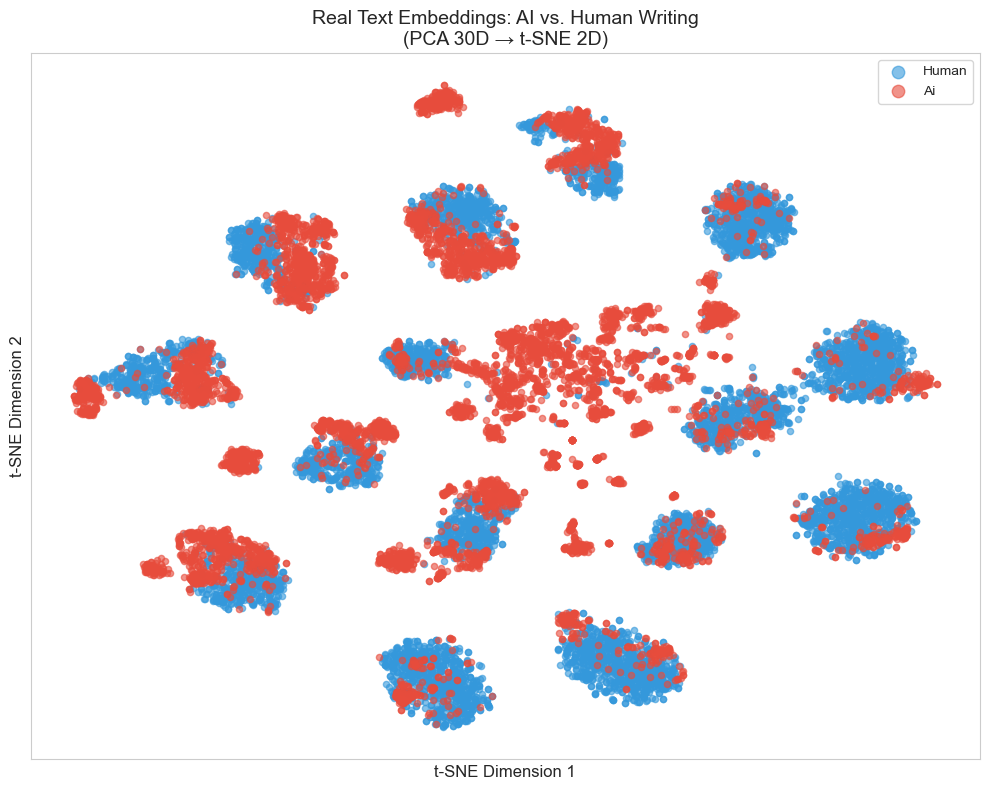


✓ Data loaded and visualized!
We'll use this dataset (df_daigt_full) throughout Section 4 for detailed analysis.


In [6]:
# Visualize the key result: can embeddings distinguish AI from human writing?
fig, ax = plt.subplots(figsize=(10, 8))

# Key Design Point 9: Color Choices for Accessibility
# Blue for human (trustworthy, natural) and red for AI (synthetic, warning)
colors = {'human': '#3498db', 'ai': '#e74c3c'}
for label_val, label_name in [(0, 'human'), (1, 'ai')]:
    mask = df_daigt_full['label'] == label_val
    ax.scatter(df_daigt_full[mask]['tsne_1'], df_daigt_full[mask]['tsne_2'], 
               c=colors[label_name], label=label_name.title(), alpha=0.6, s=20)

ax.set_xlabel('t-SNE Dimension 1', fontsize=12)
ax.set_ylabel('t-SNE Dimension 2', fontsize=12)
ax.set_title('Real Text Embeddings: AI vs. Human Writing\n(PCA 30D → t-SNE 2D)', fontsize=14)
ax.legend(markerscale=2)
ax.set_xticks([])
ax.set_yticks([])
plt.tight_layout()
plt.show()

print("\n✓ Data loaded and visualized!")
print(f"We'll use this dataset (df_daigt_full) throughout Section 4 for detailed analysis.")

**What you're seeing:** Real text embeddings reveal meaningful separation between AI-generated and human writing. The two groups cluster differently in the 2D projection, showing that embeddings capture stylistic patterns beyond just content.

**The pipeline:** Text → Normalize → Embeddings (384D) → PCA (30D) → t-SNE (2D) → Visualization

**Key observations:**
- Clusters are not perfectly separated (overlap exists)
- Some prompts may separate better than others
- Different AI models might have distinct signatures

This is exactly what we'll explore in depth throughout this notebook. Sections 1-3 build the theory, and Section 4 analyzes this dataset from multiple angles.

---
# Section 1: Building Intuition — PCA on Synthetic Data

Before jumping to formulas, let's build geometric intuition about what PCA does and when it works.

## 1.1 The Rotated Ellipse: Finding Axes of Maximum Variance

PCA finds orthogonal directions in your data that capture the most variance. Think of it as finding the "natural" coordinate system for your data.

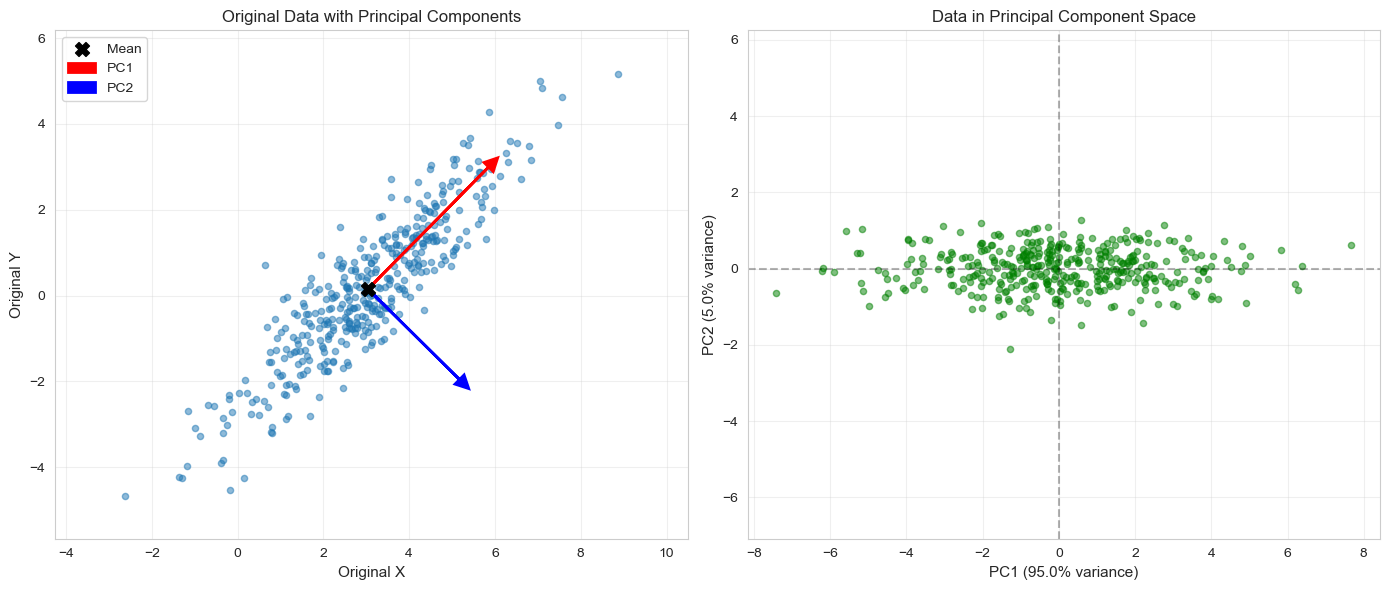

PC1 explains 95.0% of variance
PC2 explains 5.0% of variance


In [7]:
# Generate correlated 2D Gaussian data (a rotated ellipse)
# Use NON-ZERO mean so we can see the effect of centering vs. not centering
mean = [3, 0.1]  # Offset from origin
cov = [[3, 2.7], [2.7, 3]]  # Strong positive correlation
data_ellipse = np.random.multivariate_normal(mean, cov, size=400)

# Compute PCA
pca_ellipse = PCA(n_components=2)
data_ellipse_centered = data_ellipse - data_ellipse.mean(axis=0)
pca_ellipse.fit(data_ellipse_centered)

# Get principal components (directions) and explained variance
pc1 = pca_ellipse.components_[0]
pc2 = pca_ellipse.components_[1]
explained_var = pca_ellipse.explained_variance_ratio_

# Project data onto principal components
data_ellipse_pca = pca_ellipse.transform(data_ellipse_centered)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Get the mean of the data to center the arrows
data_mean_point = data_ellipse.mean(axis=0)

# Original data with PC axes starting from the mean
axes[0].scatter(data_ellipse[:, 0], data_ellipse[:, 1], alpha=0.5, s=20)
axes[0].scatter(data_mean_point[0], data_mean_point[1], c='black', s=100, 
                marker='X', label='Mean', zorder=5)
axes[0].arrow(data_mean_point[0], data_mean_point[1], pc1[0]*4, pc1[1]*4, 
              head_width=0.3, head_length=0.3, fc='red', ec='red', linewidth=2, 
              label='PC1')
axes[0].arrow(data_mean_point[0], data_mean_point[1], pc2[0]*3, pc2[1]*3, 
              head_width=0.3, head_length=0.3, fc='blue', ec='blue', linewidth=2, 
              label='PC2')
axes[0].set_xlabel('Original X', fontsize=11)
axes[0].set_ylabel('Original Y', fontsize=11)
axes[0].set_title('Original Data with Principal Components', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].axis('equal')

# Projected data onto PCs
axes[1].scatter(data_ellipse_pca[:, 0], data_ellipse_pca[:, 1], alpha=0.5, s=20, c='green')
axes[1].axhline(y=0, color='k', linestyle='--', alpha=0.3)
axes[1].axvline(x=0, color='k', linestyle='--', alpha=0.3)
axes[1].set_xlabel(f'PC1 ({explained_var[0]:.1%} variance)', fontsize=11)
axes[1].set_ylabel(f'PC2 ({explained_var[1]:.1%} variance)', fontsize=11)
axes[1].set_title('Data in Principal Component Space', fontsize=12)
axes[1].grid(True, alpha=0.3)
axes[1].axis('equal')

plt.tight_layout()
plt.show()

print(f"PC1 explains {explained_var[0]:.1%} of variance")
print(f"PC2 explains {explained_var[1]:.1%} of variance")

**Key insight:** PCA found that PC1 (red arrow) aligns with the long axis of the ellipse—the direction of maximum spread. PC2 (blue arrow) is orthogonal and captures the remaining variance.

**Mathematics connecting to the plot above:**

For centered data $\mathbf{X}_c$, PCA performs Singular Value Decomposition:
$$\mathbf{X}_c = \mathbf{U} \boldsymbol{\Sigma} \mathbf{V}^T$$

where:
- Rows of $\mathbf{V}^T$ → principal components (the red and blue arrows above)
- $\sigma_i$ (singular values) → arrow lengths represent component importance
- Explained variance: $\text{Var}_i = \frac{\sigma_i^2}{\sum_j \sigma_j^2}$ (shown in axis labels)

**In the right plot:** The axes are now PC1 and PC2, and the data spreads along these natural directions. The percentages (e.g., 94% for PC1) come directly from $\frac{\sigma_1^2}{\sum \sigma_j^2}$.

### 1.1b Centering Matters Visually

PCA requires mean centering. Without it, the first PC will just point toward the mean instead of along the variance direction.

**Note:** Our data has mean [3, 2] (not at origin). This offset lets us see the dramatic difference between centered and uncentered PCA.

Data mean: [3.04, 0.15]


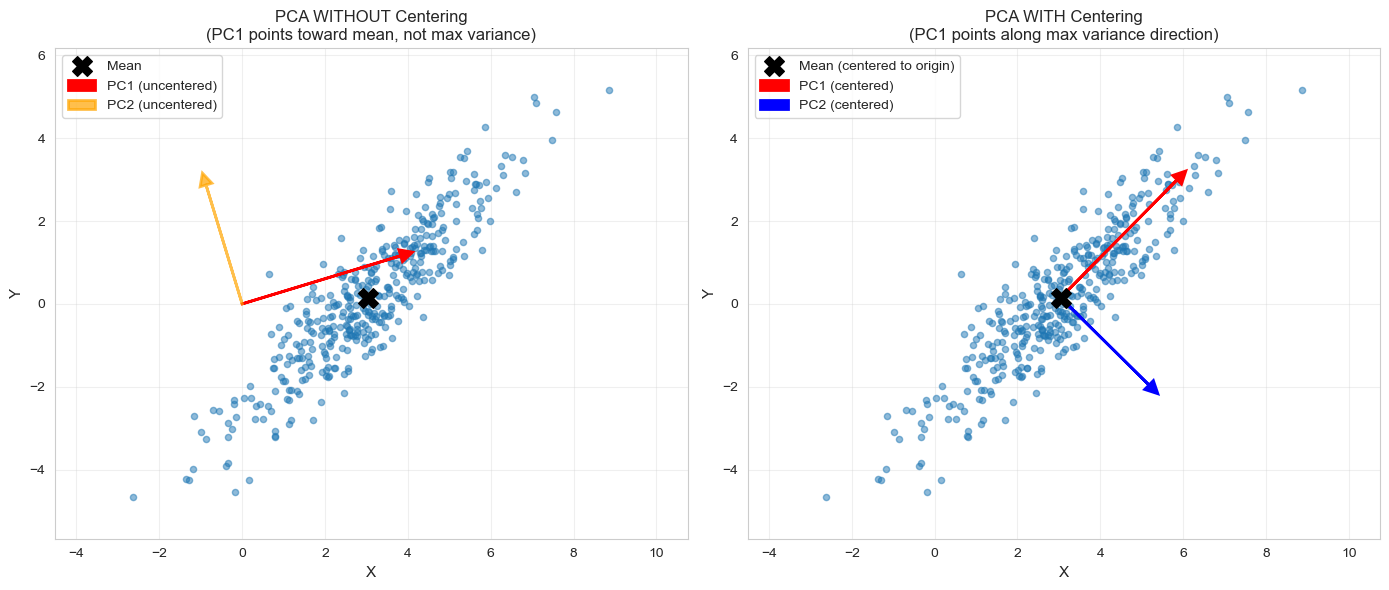

In [8]:
# Compare centered vs. uncentered PCA
# Note: sklearn's PCA() always centers automatically, so we need to manually compute uncentered PCA
# The data_ellipse was generated with mean=[3,2], so it's offset from the origin
data_mean = data_ellipse.mean(axis=0)
print(f"Data mean: [{data_mean[0]:.2f}, {data_mean[1]:.2f}]")

# Truly uncentered PCA: compute SVD on raw data (not centered)
U_uncentered, S_uncentered, Vt_uncentered = np.linalg.svd(data_ellipse, full_matrices=False)
pc1_uncentered = -Vt_uncentered[0]
pc2_uncentered = Vt_uncentered[1]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Without centering - PC1 will point from origin toward the data cloud
axes[0].scatter(data_ellipse[:, 0], data_ellipse[:, 1], alpha=0.5, s=20)
axes[0].scatter(data_mean[0], data_mean[1], c='black', s=200, marker='X', 
                label='Mean', zorder=5)
# Arrow from origin (not from mean!)
axes[0].arrow(0, 0, pc1_uncentered[0]*4, pc1_uncentered[1]*4, 
              head_width=0.3, head_length=0.3, fc='red', ec='red', linewidth=2, 
              label='PC1 (uncentered)')
axes[0].arrow(0, 0, pc2_uncentered[0]*3, pc2_uncentered[1]*3, 
              head_width=0.3, head_length=0.3, fc='orange', ec='orange', linewidth=2, 
              label='PC2 (uncentered)', alpha=0.7)
axes[0].set_xlabel('X', fontsize=11)
axes[0].set_ylabel('Y', fontsize=11)
axes[0].set_title('PCA WITHOUT Centering\n(PC1 points toward mean, not max variance)', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].axis('equal')

# With centering (from before) - PC1 points along max variance direction
axes[1].scatter(data_ellipse[:, 0], data_ellipse[:, 1], alpha=0.5, s=20)
axes[1].scatter(data_mean[0], data_mean[1], c='black', s=200, marker='X', 
                label='Mean (centered to origin)', zorder=5)
# Show PCs from the mean (conceptual origin after centering)
axes[1].arrow(data_mean[0], data_mean[1], pc1[0]*4, pc1[1]*4, 
              head_width=0.3, head_length=0.3, fc='red', ec='red', linewidth=2, 
              label='PC1 (centered)')
axes[1].arrow(data_mean[0], data_mean[1], pc2[0]*3, pc2[1]*3, 
              head_width=0.3, head_length=0.3, fc='blue', ec='blue', linewidth=2, 
              label='PC2 (centered)')
axes[1].set_xlabel('X', fontsize=11)
axes[1].set_ylabel('Y', fontsize=11)
axes[1].set_title('PCA WITH Centering\n(PC1 points along max variance direction)', fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].axis('equal')

plt.tight_layout()
plt.show()

**Why centering matters:** 

- **Left (uncentered):** PC1 points from the origin (0,0) toward the data cloud's mean, dominated by the mean's location rather than the variance structure. PC2 is orthogonal to PC1 but doesn't capture the ellipse's natural axes.

- **Right (centered):** After centering (shifting the mean to origin), PC1 aligns with the long axis of the ellipse (maximum variance direction), and PC2 captures the short axis.

**Key insight:** Uncentered PCA wastes the first component on "where is the data?" instead of "what's the data's shape?" This is why you always center first.

**In practice:** sklearn's `PCA()` centers automatically, so you don't need to worry about this. But if you ever compute PCA manually using SVD, remember to center first!

## 1.2 Variance ≠ Separability

PCA maximizes variance, but the direction of maximum variance isn't always the most informative for your task. This is PCA's fundamental limitation for supervised learning.

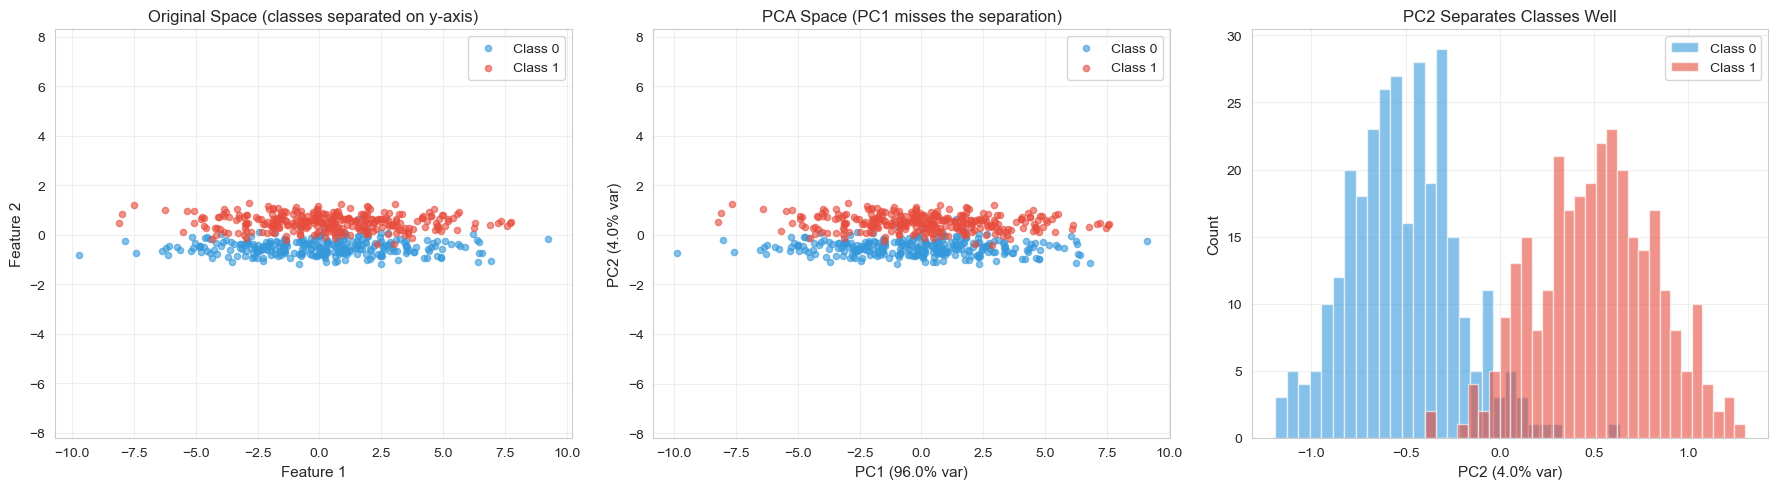

PC1 captures 96.0% of variance but doesn't separate classes
PC2 captures only 4.0% of variance but DOES separate classes


In [9]:
# Create two classes separated along a low-variance direction
np.random.seed(SEED)
n_samples = 300

# Class 0: spread widely along x-axis, tight on y-axis
class_0 = np.random.randn(n_samples, 2) * np.array([3, 0.3]) + np.array([0, -0.5])

# Class 1: same spread, slightly shifted on y-axis
class_1 = np.random.randn(n_samples, 2) * np.array([3, 0.3]) + np.array([0, 0.5])

data_classes = np.vstack([class_0, class_1])
labels = np.array([0]*n_samples + [1]*n_samples)

# Apply PCA
pca_classes = PCA(n_components=2)
pca_classes.fit(data_classes)
data_classes_pca = pca_classes.transform(data_classes)

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

colors_classes = ['#3498db', '#e74c3c']

# Original space
for i, label in enumerate(['Class 0', 'Class 1']):
    mask = labels == i
    axes[0].scatter(data_classes[mask, 0], data_classes[mask, 1], 
                    c=colors_classes[i], label=label, alpha=0.6, s=20)
axes[0].set_xlabel('Feature 1', fontsize=11)
axes[0].set_ylabel('Feature 2', fontsize=11)
axes[0].set_title('Original Space (classes separated on y-axis)', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].axis('equal')

# PC space
for i, label in enumerate(['Class 0', 'Class 1']):
    mask = labels == i
    axes[1].scatter(data_classes_pca[mask, 0], data_classes_pca[mask, 1], 
                    c=colors_classes[i], label=label, alpha=0.6, s=20)
axes[1].set_xlabel(f'PC1 ({pca_classes.explained_variance_ratio_[0]:.1%} var)', fontsize=11)
axes[1].set_ylabel(f'PC2 ({pca_classes.explained_variance_ratio_[1]:.1%} var)', fontsize=11)
axes[1].set_title('PCA Space (PC1 misses the separation)', fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].axis('equal')

# PC2 only (the separating direction)
for i, label in enumerate(['Class 0', 'Class 1']):
    mask = labels == i
    axes[2].hist(data_classes_pca[mask, 1], bins=30, alpha=0.6, 
                 color=colors_classes[i], label=label)
axes[2].set_xlabel(f'PC2 ({pca_classes.explained_variance_ratio_[1]:.1%} var)', fontsize=11)
axes[2].set_ylabel('Count', fontsize=11)
axes[2].set_title('PC2 Separates Classes Well', fontsize=12)
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"PC1 captures {pca_classes.explained_variance_ratio_[0]:.1%} of variance but doesn't separate classes")
print(f"PC2 captures only {pca_classes.explained_variance_ratio_[1]:.1%} of variance but DOES separate classes")

**Critical lesson:** The direction with the most variance (PC1, horizontal spread) tells us nothing about class membership. The separating direction (PC2, vertical shift) has low variance—only 6% of total variance!

**Implication:** PCA is unsupervised. It knows nothing about your labels. For classification, you might need supervised dimensionality reduction (like LDA) or simply use all PCs that collectively capture 95% variance.

## 1.3 The Global Structure Test: Mammoth

Can we project 3D data to 2D while preserving the overall shape? This tests a method's ability to maintain **global structure**—the relative positions of distant points.

✓ Loaded mammoth dataset: 10,000 points


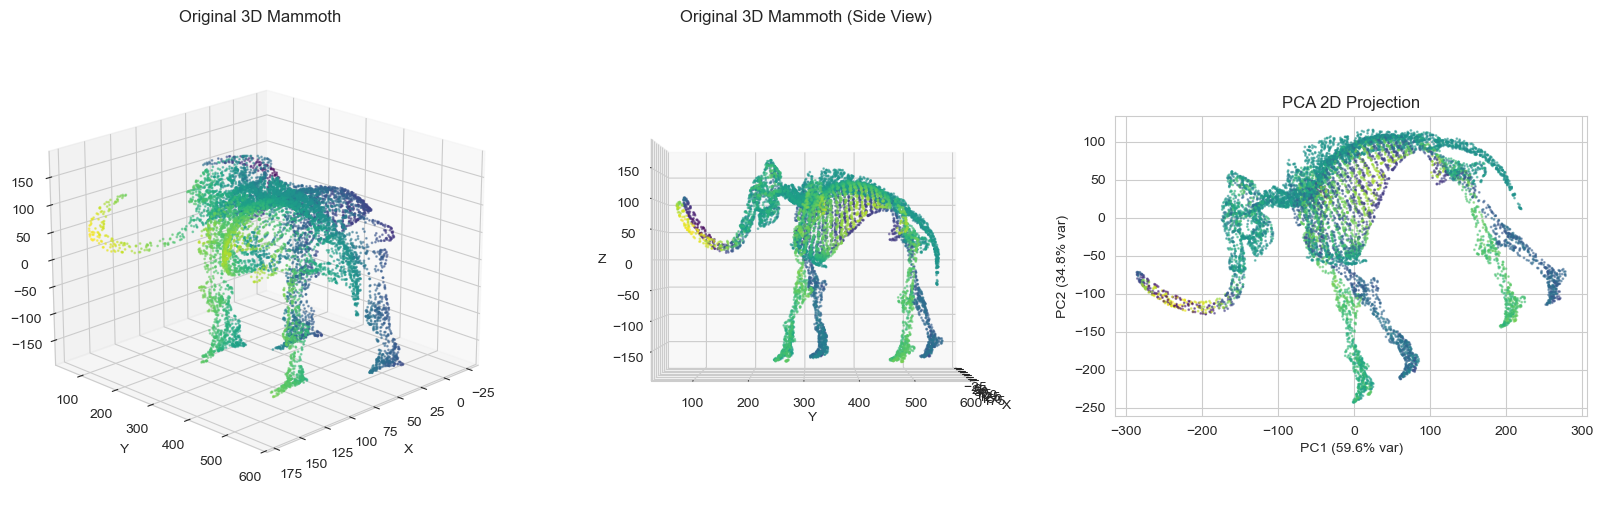

In [10]:
# Load mammoth 3D point cloud
# This is a 10k-point digitization of a mammoth skeleton
# Used to test whether DR methods preserve recognizable global structure
# Dataset source: Included in Lecture 12 directory
mammoth_path = 'mammoth_data.csv'
try:
    mammoth_df = pd.read_csv(mammoth_path)
    print(f"✓ Loaded mammoth dataset: {mammoth_df.shape[0]:,} points")
except FileNotFoundError:
    print(f"⚠️  Mammoth dataset not found at: {mammoth_path}")
    print("\nThe mammoth test demonstrates global structure preservation.")
    print("This dataset should be in the same directory as the notebook.")
    print("\nDownload options:")
    print("  1. From PaCMAP repo: https://github.com/YingfanWang/PaCMAP/raw/master/demo/mammoth_data.csv")
    print("  2. Or from original: https://github.com/MNoichl/UMAP-examples-mammoth-/raw/master/mammoth_3d.csv")
    print("  3. Save as 'mammoth_data.csv' in the same directory as this notebook")
    raise

# The CSV has columns 0, 1, 2 representing X, Y, Z coordinates
mammoth_3d = mammoth_df.values

# Apply PCA to reduce 3D → 2D
pca_mammoth = PCA(n_components=2, random_state=SEED)
mammoth_2d_pca = pca_mammoth.fit_transform(mammoth_3d)

# Visualize
fig = plt.figure(figsize=(16, 6))

# Original 3D (profile view)
ax1 = fig.add_subplot(131, projection='3d')
ax1.scatter(mammoth_3d[:, 0], mammoth_3d[:, 1], mammoth_3d[:, 2], 
            s=1, alpha=0.5, c=mammoth_3d[:, 0], cmap='viridis')
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_title('Original 3D Mammoth', fontsize=12)
ax1.view_init(elev=20, azim=45)

# Original 3D (profile view)
ax2 = fig.add_subplot(132, projection='3d')
ax2.scatter(mammoth_3d[:, 0], mammoth_3d[:, 1], mammoth_3d[:, 2], 
            s=1, alpha=0.5, c=mammoth_3d[:, 0], cmap='viridis')
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax2.set_title('Original 3D Mammoth (Side View)', fontsize=12)
ax2.view_init(elev=0, azim=0)

# PCA 2D projection
ax3 = fig.add_subplot(133)
ax3.scatter(mammoth_2d_pca[:, 0], mammoth_2d_pca[:, 1], 
            s=1, alpha=0.5, c=mammoth_3d[:, 0], cmap='viridis')
ax3.set_xlabel(f'PC1 ({pca_mammoth.explained_variance_ratio_[0]:.1%} var)')
ax3.set_ylabel(f'PC2 ({pca_mammoth.explained_variance_ratio_[1]:.1%} var)')
ax3.set_title('PCA 2D Projection', fontsize=12)
ax3.set_aspect('equal')

plt.tight_layout()
plt.show()

**The Global Structure Test:** Can you still recognize it as a mammoth? 

**PCA succeeds here** because the mammoth's natural dimensions are its length (head to tail) and height. PC1 ≈ length, PC2 ≈ height. The projection preserves the overall shape—we can still see it's a mammoth skeleton, just "crushed onto the page."

**Key insight:** PCA preserves **global structure** (relative positions of distant points, overall shape) but not necessarily **local structure** (fine details like individual toes or bone connections).

**Foreshadowing:** In Section 3, we'll see that t-SNE and UMAP break the mammoth apart into disconnected blobs because they prioritize local neighborhoods over global shape!

---
# Section 2: PCA Step-by-Step — Core Method

Now that we have intuition, let's understand the mechanics and how to use PCA effectively.

## 2.1 The Mathematics: From Data to Components

**The PCA algorithm:**

1. **Center the data:** $\mathbf{X}_c = \mathbf{X} - \bar{\mathbf{X}}$ (subtract column means)

2. **Singular Value Decomposition (SVD):**
   $$\mathbf{X}_c = \mathbf{U} \boldsymbol{\Sigma} \mathbf{V}^T$$
   where:
   - $\mathbf{U}$: Left singular vectors (n_samples × n_components)
   - $\boldsymbol{\Sigma}$: Diagonal matrix of singular values $\sigma_1 \geq \sigma_2 \geq \ldots$
   - $\mathbf{V}^T$: Right singular vectors (n_components × n_features) — **these are the principal components**

3. **Explained variance:** 
   $$\text{Var}_i = \frac{\sigma_i^2}{\sum_j \sigma_j^2}$$

4. **Project data:** $\mathbf{Z} = \mathbf{X}_c \mathbf{V}$ (scores in PC space)

5. **Reconstruct:** $\hat{\mathbf{X}}_c = \mathbf{Z} \mathbf{V}^T = \mathbf{X}_c \mathbf{V} \mathbf{V}^T$

**Alternative view (covariance):** PCA finds eigenvectors of the covariance matrix $\mathbf{C} = \frac{1}{n-1}\mathbf{X}_c^T \mathbf{X}_c$. SVD is more numerically stable and faster.

In [11]:
# PCA from scratch using SVD
def pca_from_scratch(X, n_components=2):
    """
    Implements PCA using SVD.
    
    Returns:
    - Z: Projected data (scores)
    - components: Principal components (V^T)
    - explained_var_ratio: Fraction of variance explained by each PC
    - X_reconstructed: Reconstructed data
    """
    # Step 1: Center the data
    X_mean = X.mean(axis=0)
    X_centered = X - X_mean
    
    # Step 2: SVD
    U, S, Vt = np.linalg.svd(X_centered, full_matrices=False)
    
    # Step 3: Select top n_components
    Vt = Vt[:n_components, :]
    S = S[:n_components]
    U = U[:, :n_components]
    
    # Step 4: Explained variance
    explained_variance = (S ** 2) / (X.shape[0] - 1)
    total_variance = np.sum((X_centered ** 2)) / (X.shape[0] - 1)
    explained_var_ratio = explained_variance / total_variance
    
    # Step 5: Project data (Z = X_c @ V)
    Z = X_centered @ Vt.T
    
    # Step 6: Reconstruct (X_c ≈ Z @ V^T)
    X_reconstructed = Z @ Vt + X_mean
    
    return Z, Vt, explained_var_ratio, X_reconstructed

# Test on ellipse data
Z_scratch, Vt_scratch, evr_scratch, X_recon_scratch = pca_from_scratch(data_ellipse, n_components=2)

print("PCA from scratch:")
print(f"PC1 explains {evr_scratch[0]:.1%}, PC2 explains {evr_scratch[1]:.1%}")
print(f"Principal components shape: {Vt_scratch.shape}")
print(f"Projected data shape: {Z_scratch.shape}")

# Verify against sklearn
pca_sklearn = PCA(n_components=2).fit(data_ellipse)
print(f"\nsklearn PCA: PC1 {pca_sklearn.explained_variance_ratio_[0]:.1%}, "
      f"PC2 {pca_sklearn.explained_variance_ratio_[1]:.1%}")
print("Match! ✓")

PCA from scratch:
PC1 explains 95.0%, PC2 explains 5.0%
Principal components shape: (2, 2)
Projected data shape: (400, 2)

sklearn PCA: PC1 95.0%, PC2 5.0%
Match! ✓


**Sign ambiguity:** Notice that principal components can flip signs (PC1 might point left or right). Only the **subspace** matters, not the direction. If you run PCA twice, you might get $\mathbf{v}_1$ or $-\mathbf{v}_1$—both are correct.

## 2.2 Choosing k: How Many Components?

Two tools: the **scree plot** (elbow method) and **cumulative explained variance**.

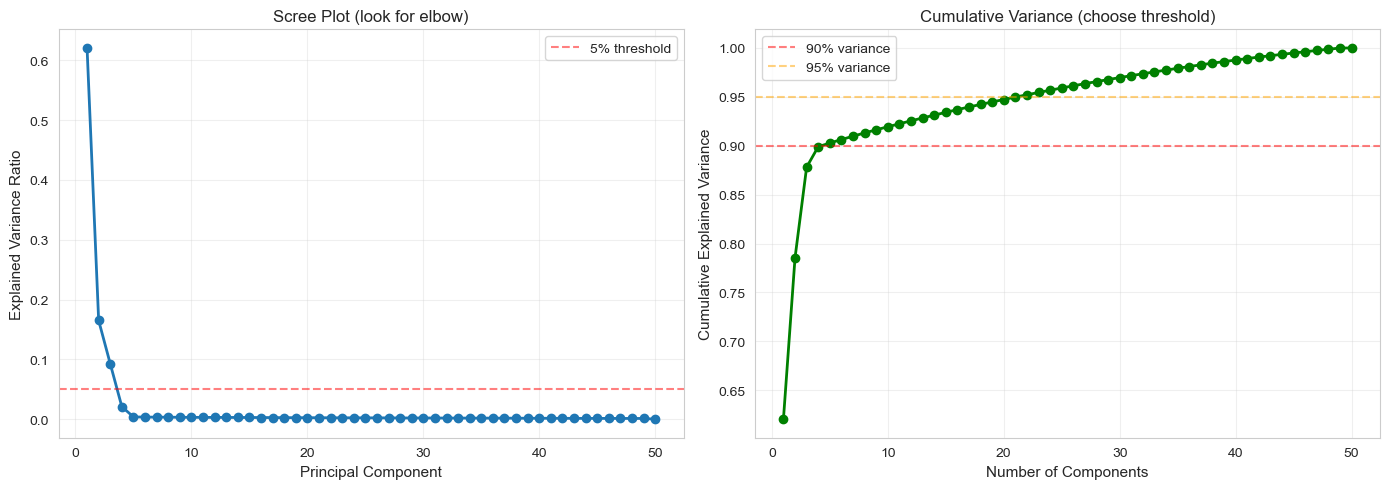

For 90% variance: need 5 components
For 95% variance: need 22 components

Sklearn auto-selection: PCA(n_components=0.95) keeps enough PCs to reach 95% variance


In [12]:
# Generate higher-dimensional data
np.random.seed(SEED)
n_samples = 500
n_features = 50

# Create data where first few dimensions have signal, rest is noise
signal_dims = 5
X_highdim = np.random.randn(n_samples, signal_dims) @ np.random.randn(signal_dims, signal_dims)
noise = np.random.randn(n_samples, n_features - signal_dims) * 0.3
X_highdim = np.hstack([X_highdim, noise])

# Fit PCA with all components
pca_full = PCA().fit(X_highdim)

# Cumulative variance
cumvar = np.cumsum(pca_full.explained_variance_ratio_)

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scree plot
axes[0].plot(range(1, len(pca_full.explained_variance_ratio_) + 1), 
             pca_full.explained_variance_ratio_, 'o-', linewidth=2)
axes[0].axhline(y=0.05, color='r', linestyle='--', alpha=0.5, label='5% threshold')
axes[0].set_xlabel('Principal Component', fontsize=11)
axes[0].set_ylabel('Explained Variance Ratio', fontsize=11)
axes[0].set_title('Scree Plot (look for elbow)', fontsize=12)
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# Cumulative variance
axes[1].plot(range(1, len(cumvar) + 1), cumvar, 'o-', linewidth=2, color='green')
axes[1].axhline(y=0.90, color='r', linestyle='--', alpha=0.5, label='90% variance')
axes[1].axhline(y=0.95, color='orange', linestyle='--', alpha=0.5, label='95% variance')
axes[1].set_xlabel('Number of Components', fontsize=11)
axes[1].set_ylabel('Cumulative Explained Variance', fontsize=11)
axes[1].set_title('Cumulative Variance (choose threshold)', fontsize=12)
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()

# Find components for different thresholds
k_90 = np.argmax(cumvar >= 0.90) + 1
k_95 = np.argmax(cumvar >= 0.95) + 1

print(f"For 90% variance: need {k_90} components")
print(f"For 95% variance: need {k_95} components")
print(f"\nSklearn auto-selection: PCA(n_components=0.95) keeps enough PCs to reach 95% variance")

**Rule of thumb:**
- For **exploratory analysis**: 2-3 components for visualization
- For **preprocessing** before ML: 90-95% cumulative variance (often 20-50 components for text embeddings)
- For **compression**: Balance information loss vs. storage/speed

**Sklearn trick:** Use `PCA(n_components=0.95)` to automatically select enough components to reach 95% variance.

## 2.3 Outliers and Scaling

PCA is sensitive to outliers (they have high variance!) and to feature scales.

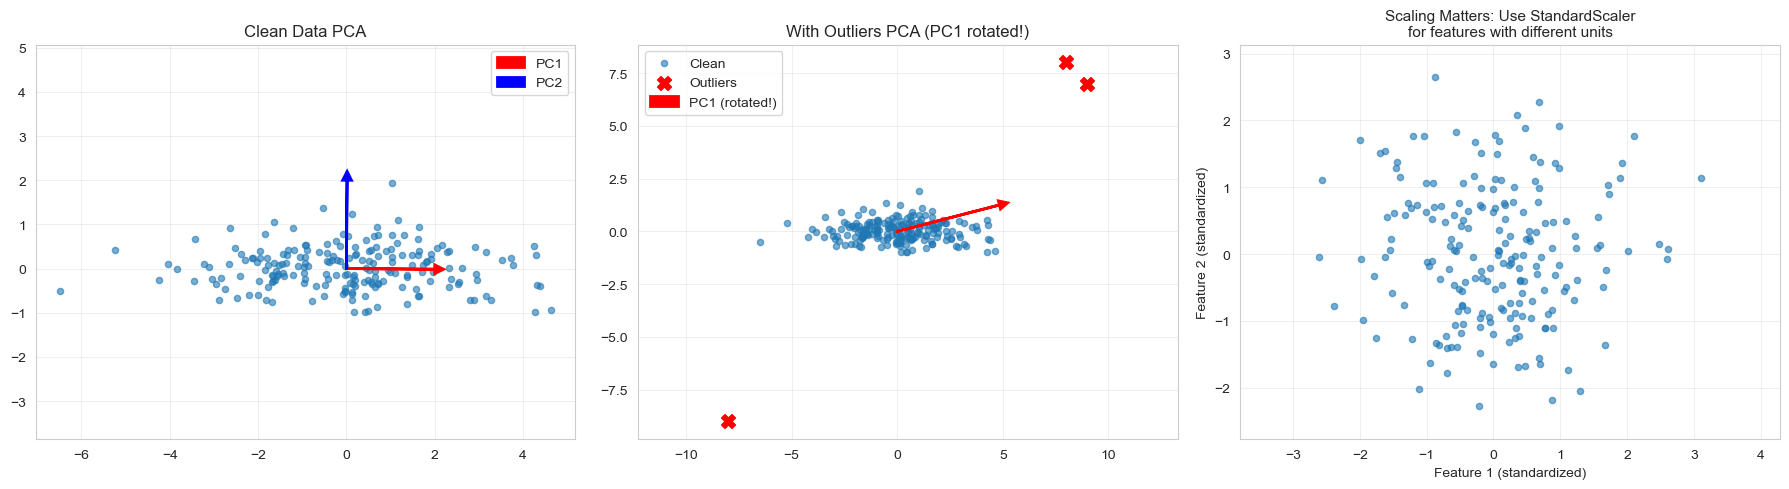

Clean data: PC1 explains 94.0%
With outliers: PC1 explains 83.9%

Outliers rotate the principal components toward them!


In [32]:
# Create clean data
np.random.seed(SEED)
clean_data = np.random.randn(200, 2) * np.array([2, 0.5])

# Add a few extreme outliers
outliers = np.array([[8, 8], [9, 7], [-8, -9]])
data_with_outliers = np.vstack([clean_data, outliers])

# PCA on both
pca_clean = PCA(n_components=2).fit(clean_data)
pca_outliers = PCA(n_components=2).fit(data_with_outliers)

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Clean data
axes[0].scatter(clean_data[:, 0], clean_data[:, 1], alpha=0.6, s=20)
pc1 = pca_clean.components_[0]
pc2 = pca_clean.components_[1]
axes[0].arrow(0, 0, pc1[0]*2, pc1[1]*2, head_width=0.2, head_length=0.2, 
              fc='red', ec='red', linewidth=2, label='PC1')
axes[0].arrow(0, 0, pc2[0]*2, pc2[1]*2, head_width=0.2, head_length=0.2, 
              fc='blue', ec='blue', linewidth=2, label='PC2')
axes[0].set_title('Clean Data PCA', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].axis('equal')

# Data with outliers
axes[1].scatter(data_with_outliers[:-3, 0], data_with_outliers[:-3, 1], 
                alpha=0.6, s=20, label='Clean')
axes[1].scatter(data_with_outliers[-3:, 0], data_with_outliers[-3:, 1], 
                c='red', s=100, marker='X', label='Outliers', zorder=5)
pc1_out = pca_outliers.components_[0]
pc2_out = pca_outliers.components_[1]
axes[1].arrow(0, 0, pc1_out[0]*5, pc1_out[1]*5, head_width=0.4, head_length=0.4, 
              fc='red', ec='red', linewidth=2, label='PC1 (rotated!)')
axes[1].set_title('With Outliers PCA (PC1 rotated!)', fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].axis('equal')

# Scaling example: features with different units
data_unscaled = np.random.randn(200, 2) * np.array([10, 0.1])  # Large scale vs small scale
data_scaled = (data_unscaled - data_unscaled.mean(axis=0)) / data_unscaled.std(axis=0)

pca_unscaled = PCA(n_components=2).fit(data_unscaled)
pca_scaled = PCA(n_components=2).fit(data_scaled)

axes[2].scatter(data_scaled[:, 0], data_scaled[:, 1], alpha=0.6, s=20)
axes[2].set_title('Scaling Matters: Use StandardScaler\nfor features with different units', fontsize=11)
axes[2].set_xlabel('Feature 1 (standardized)')
axes[2].set_ylabel('Feature 2 (standardized)')
axes[2].grid(True, alpha=0.3)
axes[2].axis('equal')

plt.tight_layout()
plt.show()

print(f"Clean data: PC1 explains {pca_clean.explained_variance_ratio_[0]:.1%}")
print(f"With outliers: PC1 explains {pca_outliers.explained_variance_ratio_[0]:.1%}")
print("\nOutliers rotate the principal components toward them!")


**Key takeaways:**
1. **Outliers:** A few extreme points can rotate PCs because they have high variance. Consider robust scaling or outlier removal.
2. **Scaling:** PCA is scale-sensitive. If features have different units (e.g., temperature in Kelvin vs. salary in dollars), always standardize first using `StandardScaler`.
3. **Sklearn's PCA:** Centers data automatically but does NOT scale. You must scale manually if needed.

## 2.4 Nonlinear Structures: Where PCA Fails

PCA is linear—it finds the best flat subspace. But real data often lies on curved manifolds. To demonstrate this limitation, we'll embed simple 2D nonlinear structures (circles, moons) in 10D space, then show that PCA cannot recover the separability when reducing back to 2D.

Embedded dimensions:
  Circles: (600, 10) (original 2D structure in 10D)
  Moons: (600, 10) (original 2D structure in 10D)
  Swiss roll: (1000, 10) (original 3D structure in 10D)


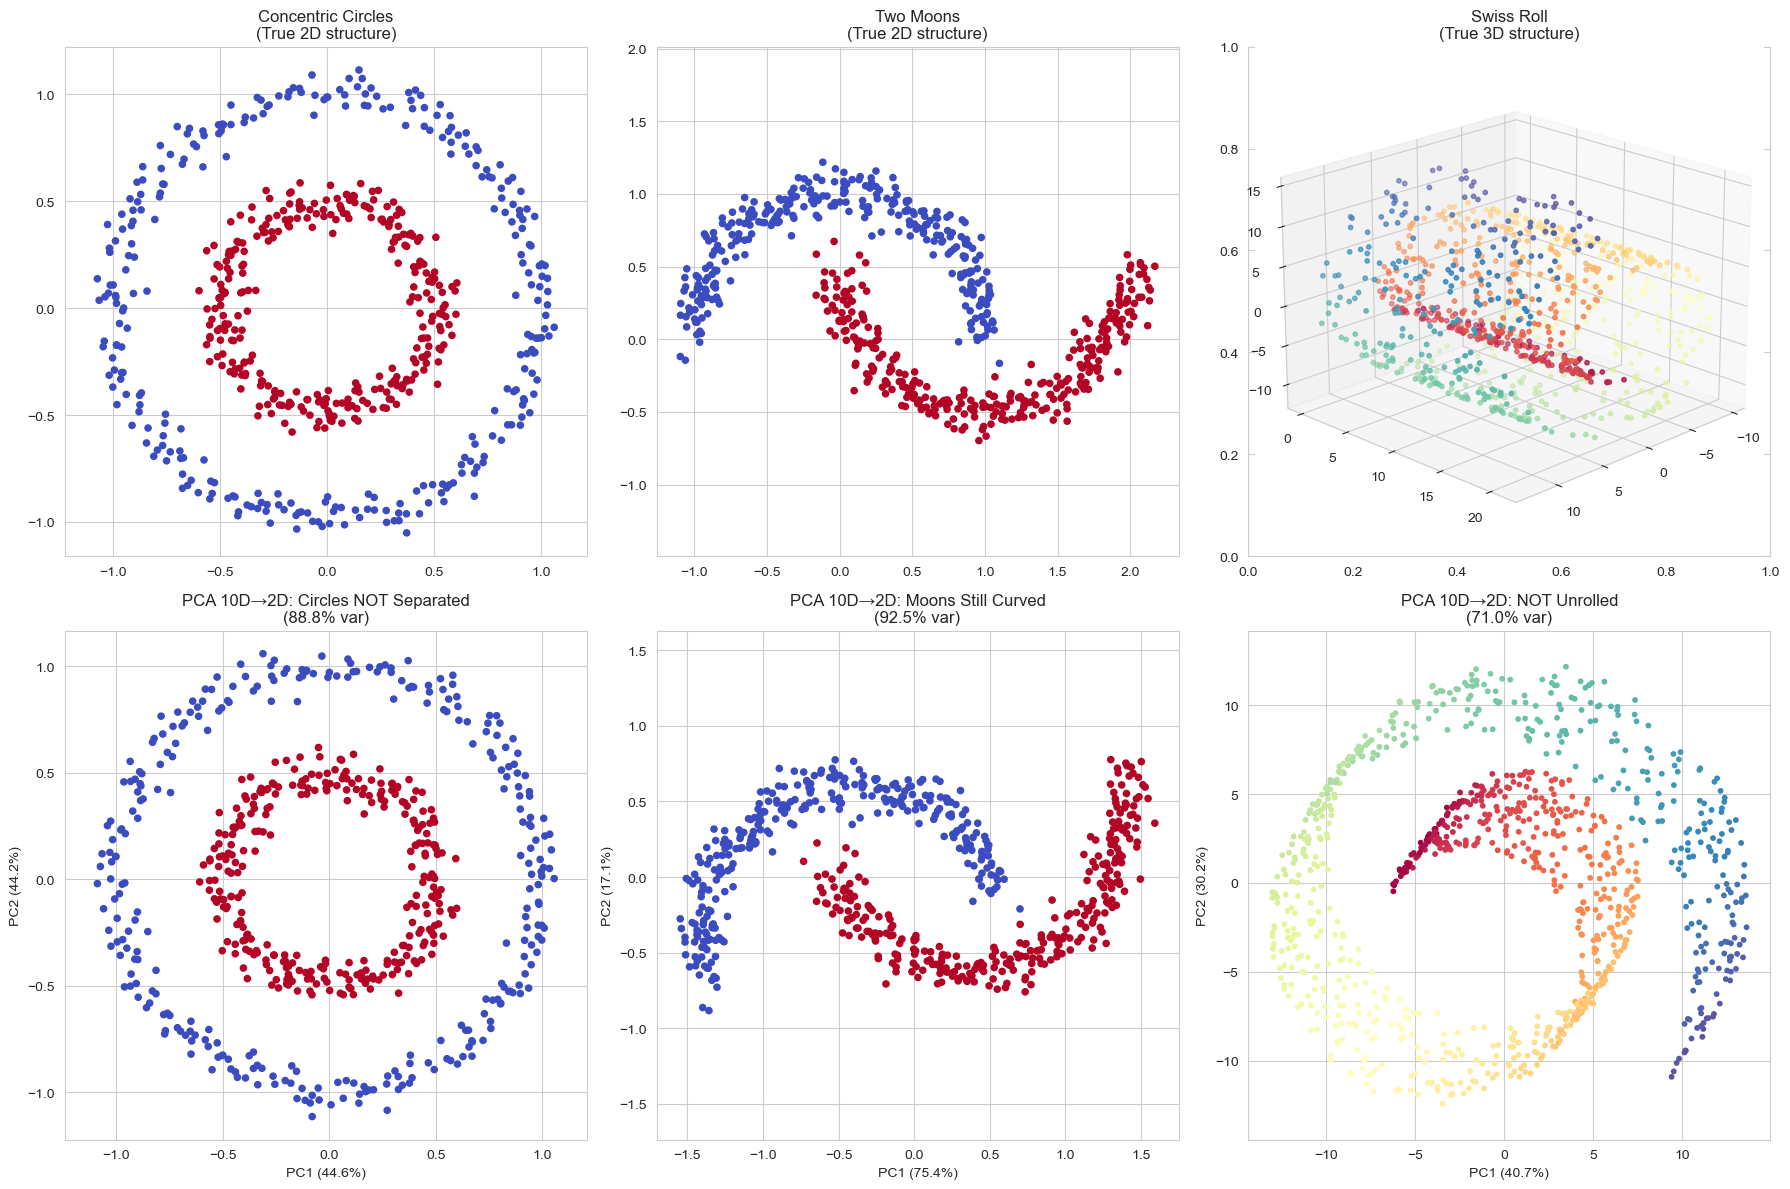


✗ PCA cannot separate concentric circles (inner vs outer)
✗ PCA cannot untangle the moons (they remain curved)
✗ PCA cannot unroll the Swiss roll (should be a flat ribbon)

The nonlinear structure is preserved in the data, but PCA's linear projection cannot recover it!


In [15]:
# Generate three classic nonlinear datasets
# KEY FIX: Embed 2D structures in high-D space to properly test PCA's limitations
np.random.seed(SEED)

# 1. Concentric circles (2D) → embed in 10D
X_circles_2d, y_circles = make_circles(n_samples=600, noise=0.05, factor=0.5, random_state=SEED)
# Embed in 10D by adding random orthogonal dimensions
n_extra_dims = 8
X_circles = np.hstack([X_circles_2d, np.random.randn(len(X_circles_2d), n_extra_dims) * 0.1])

# 2. Two moons (2D) → embed in 10D
X_moons_2d, y_moons = make_moons(n_samples=600, noise=0.08, random_state=SEED)
X_moons = np.hstack([X_moons_2d, np.random.randn(len(X_moons_2d), n_extra_dims) * 0.1])

# 3. Swiss roll (3D) → embed in 10D
X_roll_3d, t_roll = make_swiss_roll(n_samples=1000, noise=0.1, random_state=SEED)
X_roll = np.hstack([X_roll_3d, np.random.randn(len(X_roll_3d), 7) * 0.1])

print(f"Embedded dimensions:")
print(f"  Circles: {X_circles.shape} (original 2D structure in 10D)")
print(f"  Moons: {X_moons.shape} (original 2D structure in 10D)")
print(f"  Swiss roll: {X_roll.shape} (original 3D structure in 10D)")

# Apply PCA to reduce back to 2D
pca_circles = PCA(n_components=2, random_state=SEED)
X_circles_pca = pca_circles.fit_transform(X_circles)

pca_moons = PCA(n_components=2, random_state=SEED)
X_moons_pca = pca_moons.fit_transform(X_moons)

pca_roll = PCA(n_components=2, random_state=SEED)
X_roll_pca = pca_roll.fit_transform(X_roll)

# Visualize
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Row 1: Original 2D/3D structure (before embedding in high-D)
axes[0, 0].scatter(X_circles_2d[:, 0], X_circles_2d[:, 1], c=y_circles, cmap='coolwarm', s=20)
axes[0, 0].set_title('Concentric Circles\n(True 2D structure)', fontsize=12)
axes[0, 0].axis('equal')

axes[0, 1].scatter(X_moons_2d[:, 0], X_moons_2d[:, 1], c=y_moons, cmap='coolwarm', s=20)
axes[0, 1].set_title('Two Moons\n(True 2D structure)', fontsize=12)
axes[0, 1].axis('equal')

axes[0, 2] = fig.add_subplot(2, 3, 3, projection='3d')
axes[0, 2].scatter(X_roll_3d[:, 0], X_roll_3d[:, 1], X_roll_3d[:, 2], c=t_roll, cmap='Spectral', s=10)
axes[0, 2].set_title('Swiss Roll\n(True 3D structure)', fontsize=12)
axes[0, 2].view_init(elev=20, azim=45)

# Row 2: PCA recovery from 10D back to 2D - showing the failure!
axes[1, 0].scatter(X_circles_pca[:, 0], X_circles_pca[:, 1], c=y_circles, cmap='coolwarm', s=20)
axes[1, 0].set_title(f'PCA 10D→2D: Circles NOT Separated\n({pca_circles.explained_variance_ratio_.sum():.1%} var)', fontsize=12)
axes[1, 0].set_xlabel(f'PC1 ({pca_circles.explained_variance_ratio_[0]:.1%})')
axes[1, 0].set_ylabel(f'PC2 ({pca_circles.explained_variance_ratio_[1]:.1%})')
axes[1, 0].axis('equal')

axes[1, 1].scatter(X_moons_pca[:, 0], X_moons_pca[:, 1], c=y_moons, cmap='coolwarm', s=20)
axes[1, 1].set_title(f'PCA 10D→2D: Moons Still Curved\n({pca_moons.explained_variance_ratio_.sum():.1%} var)', fontsize=12)
axes[1, 1].set_xlabel(f'PC1 ({pca_moons.explained_variance_ratio_[0]:.1%})')
axes[1, 1].set_ylabel(f'PC2 ({pca_moons.explained_variance_ratio_[1]:.1%})')
axes[1, 1].axis('equal')

axes[1, 2].scatter(X_roll_pca[:, 0], X_roll_pca[:, 1], c=t_roll, cmap='Spectral', s=10)
axes[1, 2].set_title(f'PCA 10D→2D: NOT Unrolled\n({pca_roll.explained_variance_ratio_.sum():.1%} var)', fontsize=12)
axes[1, 2].set_xlabel(f'PC1 ({pca_roll.explained_variance_ratio_[0]:.1%})')
axes[1, 2].set_ylabel(f'PC2 ({pca_roll.explained_variance_ratio_[1]:.1%})')
axes[1, 2].axis('equal')

plt.tight_layout()
plt.show()

print(f"\n✗ PCA cannot separate concentric circles (inner vs outer)")
print(f"✗ PCA cannot untangle the moons (they remain curved)")
print(f"✗ PCA cannot unroll the Swiss roll (should be a flat ribbon)")
print(f"\nThe nonlinear structure is preserved in the data, but PCA's linear projection cannot recover it!")

**PCA's limitation:** These datasets have **nonlinear structure** (circles, crescents, rolled surfaces) embedded in high-dimensional space. Even though the true structure is 2D, PCA cannot recover it because the manifold is curved.

**What we demonstrated:**
- Top row: The true 2D/3D structure (what we'd ideally recover)
- Bottom row: What PCA actually gives us when reducing from 10D to 2D

**The failure modes:**
- **Circles:** PCA cannot separate inner from outer circle (both classes still overlap)
- **Moons:** PCA keeps them curved and overlapping (no linear projection can untangle them)
- **Swiss roll:** PCA doesn't unroll it into a flat ribbon (it stays rolled up)

**Why this matters:** Many real datasets have nonlinear structure—facial expressions lie on curved manifolds, handwritten digits cluster in nonlinear ways, text topics form curved boundaries. For visualization and cluster discovery, we need **nonlinear dimensionality reduction** methods. That's what Section 3 is about.

**Key insight:** Even when the true intrinsic dimension is low (2D), if the structure is nonlinear (curved), PCA will fail to find a good 2D representation. We need methods that can "unfold" or "untangle" curved manifolds.

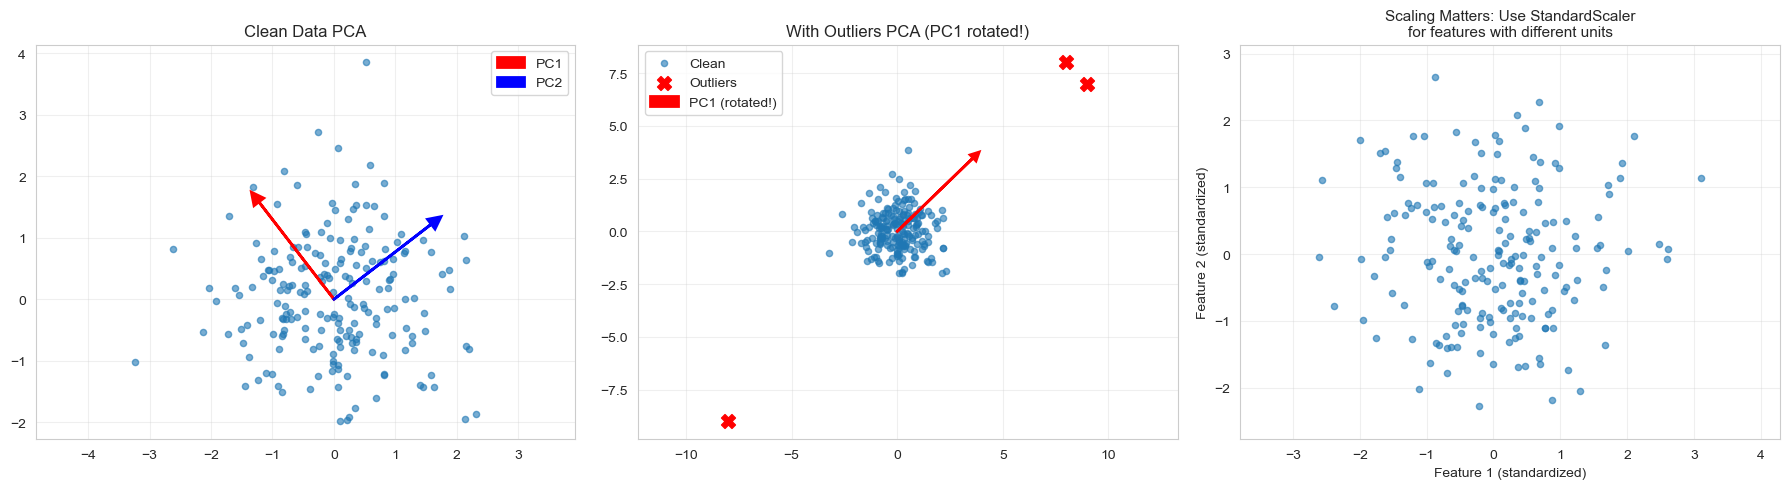

Clean data: PC1 explains 51.5%
With outliers: PC1 explains 75.1%

Outliers rotate the principal components toward them!


In [16]:
# Create clean data
np.random.seed(SEED)
clean_data = np.random.randn(200, 2) * np.array([1, 1])

# Add a few extreme outliers
outliers = np.array([[8, 8], [9, 7], [-8, -9]])
data_with_outliers = np.vstack([clean_data, outliers])

# PCA on both
pca_clean = PCA(n_components=2).fit(clean_data)
pca_outliers = PCA(n_components=2).fit(data_with_outliers)

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Clean data
axes[0].scatter(clean_data[:, 0], clean_data[:, 1], alpha=0.6, s=20)
pc1 = pca_clean.components_[0]
pc2 = pca_clean.components_[1]
axes[0].arrow(0, 0, pc1[0]*2, pc1[1]*2, head_width=0.2, head_length=0.2, 
              fc='red', ec='red', linewidth=2, label='PC1')
axes[0].arrow(0, 0, pc2[0]*2, pc2[1]*2, head_width=0.2, head_length=0.2, 
              fc='blue', ec='blue', linewidth=2, label='PC2')
axes[0].set_title('Clean Data PCA', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].axis('equal')

# Data with outliers
axes[1].scatter(data_with_outliers[:-3, 0], data_with_outliers[:-3, 1], 
                alpha=0.6, s=20, label='Clean')
axes[1].scatter(data_with_outliers[-3:, 0], data_with_outliers[-3:, 1], 
                c='red', s=100, marker='X', label='Outliers', zorder=5)
pc1_out = pca_outliers.components_[0]
pc2_out = pca_outliers.components_[1]
axes[1].arrow(0, 0, pc1_out[0]*5, pc1_out[1]*5, head_width=0.4, head_length=0.4, 
              fc='red', ec='red', linewidth=2, label='PC1 (rotated!)')
axes[1].set_title('With Outliers PCA (PC1 rotated!)', fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].axis('equal')

# Scaling example: features with different units
data_unscaled = np.random.randn(200, 2) * np.array([10, 0.1])  # Large scale vs small scale
data_scaled = (data_unscaled - data_unscaled.mean(axis=0)) / data_unscaled.std(axis=0)

pca_unscaled = PCA(n_components=2).fit(data_unscaled)
pca_scaled = PCA(n_components=2).fit(data_scaled)

axes[2].scatter(data_scaled[:, 0], data_scaled[:, 1], alpha=0.6, s=20)
axes[2].set_title('Scaling Matters: Use StandardScaler\nfor features with different units', fontsize=11)
axes[2].set_xlabel('Feature 1 (standardized)')
axes[2].set_ylabel('Feature 2 (standardized)')
axes[2].grid(True, alpha=0.3)
axes[2].axis('equal')

plt.tight_layout()
plt.show()

print(f"Clean data: PC1 explains {pca_clean.explained_variance_ratio_[0]:.1%}")
print(f"With outliers: PC1 explains {pca_outliers.explained_variance_ratio_[0]:.1%}")
print("\nOutliers rotate the principal components toward them!")

---
# Section 3: Nonlinear Visualizers — Beyond PCA

PCA preserves global structure but struggles with local neighborhoods and nonlinear manifolds. When we need to see clusters and local patterns—especially for visualization—we turn to nonlinear methods. But these come with trade-offs.

## 3.1 t-SNE: The Cluster Finder

**t-distributed Stochastic Neighbor Embedding (t-SNE)** converts high-dimensional distances into probabilities and minimizes their divergence in low-D.

**How it works:**
1. In high-D: Model pairwise similarities using Gaussian distributions
2. In low-D: Model similarities using Student-t distributions (heavier tails)
3. Minimize KL divergence: $KL(P || Q) = \sum_{ij} p_{ij} \log \frac{p_{ij}}{q_{ij}}$

**Key parameter:** `perplexity` ≈ effective number of neighbors (typically 5-50)

**Strengths:** Excellent at revealing local clusters  
**Weaknesses:** Global distances meaningless; slow; non-deterministic; no parametric transform

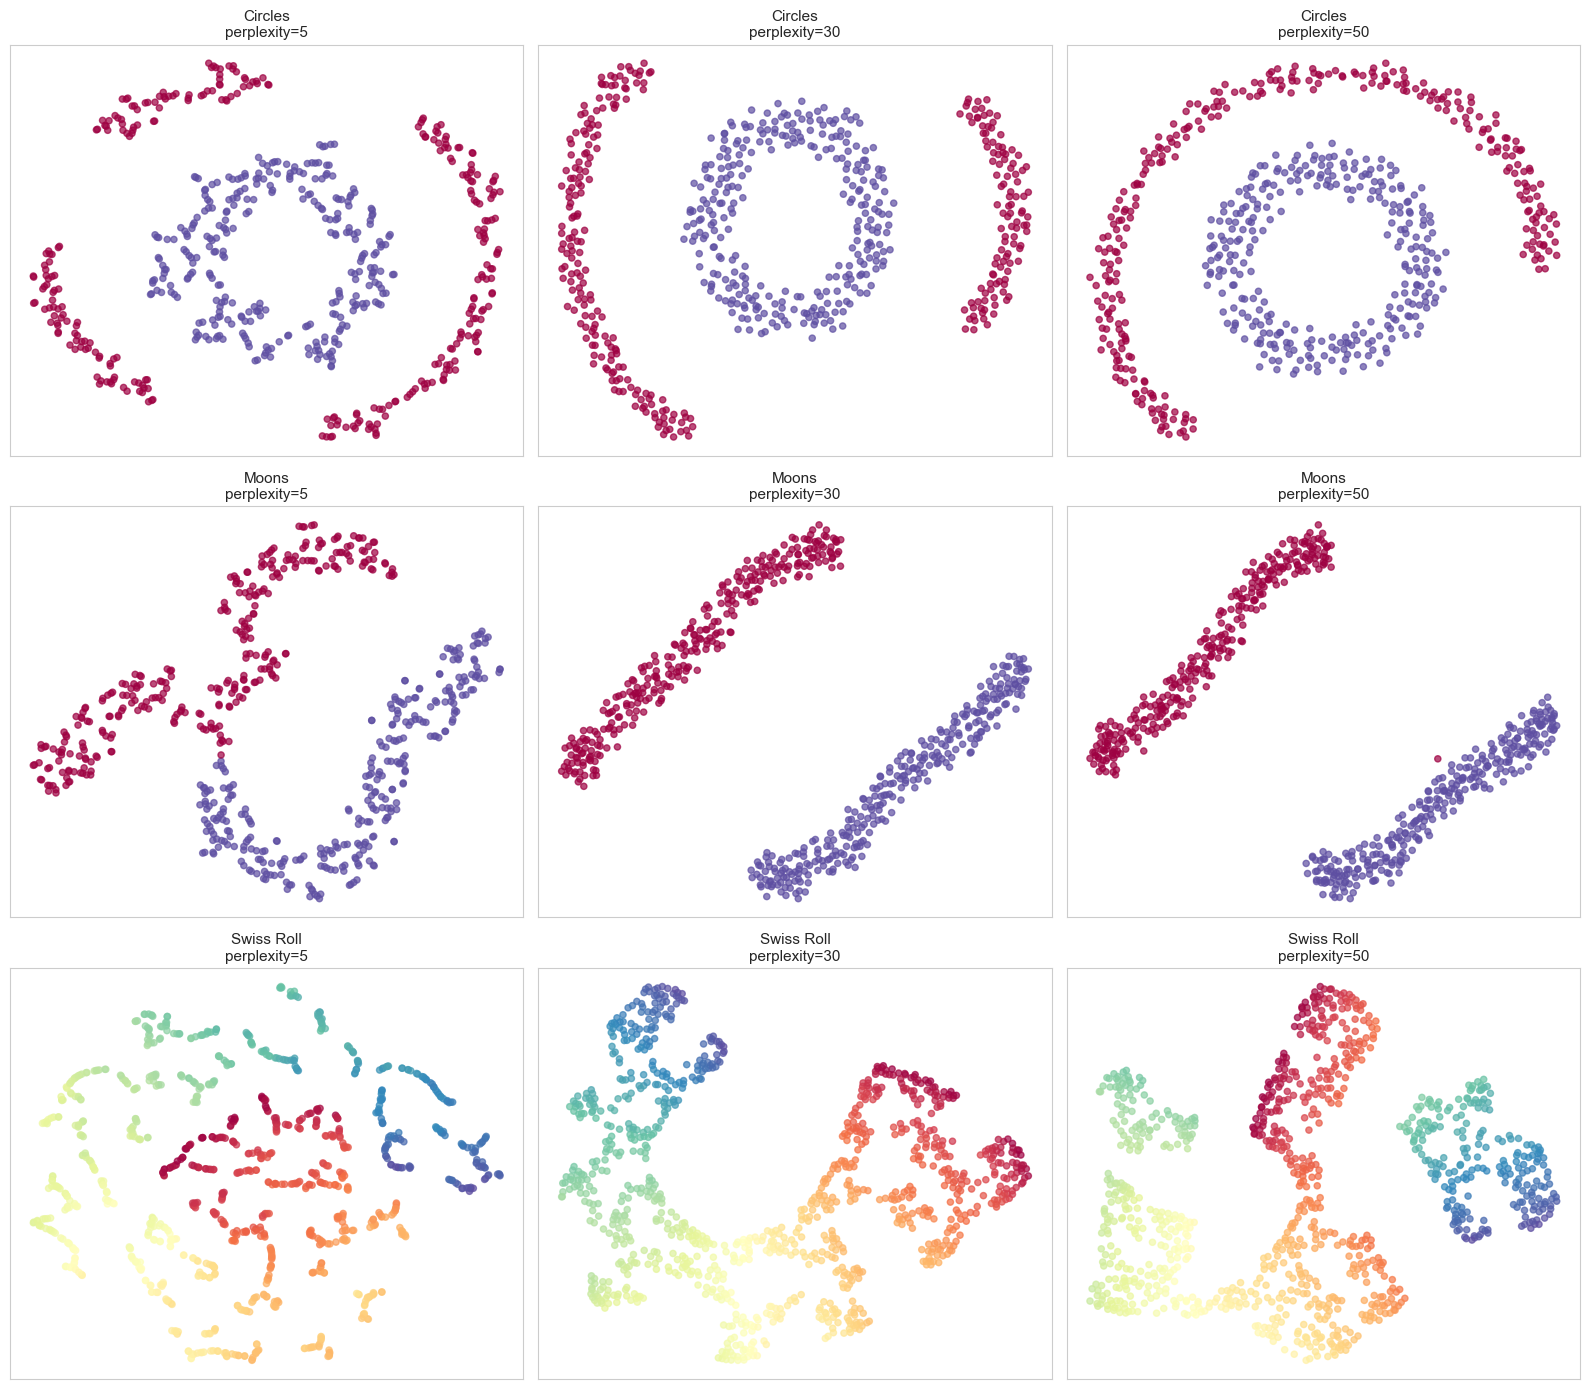

In [17]:
# Apply t-SNE to our nonlinear datasets with different perplexities
perplexities = [5, 30, 50]

fig, axes = plt.subplots(3, len(perplexities), figsize=(16, 14))

datasets = [
    (X_circles, y_circles, 'Circles'),
    (X_moons, y_moons, 'Moons'),
    (X_roll, t_roll, 'Swiss Roll')
]

for row, (X, y, name) in enumerate(datasets):
    for col, perp in enumerate(perplexities):
        # Reduce to 30D with PCA first for high-D data (swiss roll is only 3D, so skip PCA)
        if X.shape[1] > 30:
            X_pre = PCA(n_components=30, random_state=SEED).fit_transform(X)
        else:
            X_pre = X
            
        tsne = TSNE(n_components=2, perplexity=perp, init='pca', random_state=SEED)
        X_tsne = tsne.fit_transform(X_pre)
        
        scatter = axes[row, col].scatter(X_tsne[:, 0], X_tsne[:, 1], 
                                        c=y, cmap='Spectral', s=20, alpha=0.7)
        axes[row, col].set_title(f'{name}\nperplexity={perp}', fontsize=11)
        axes[row, col].set_xticks([])
        axes[row, col].set_yticks([])

plt.tight_layout()
plt.show()

**What you're seeing:**
- **Low perplexity (5):** Focuses on very local structure, can over-fragment
- **Medium perplexity (30):** Balanced view, good default
- **High perplexity (50):** More global context, but can miss fine clusters

**Critical warning:** The distances between clusters in t-SNE are **meaningless**. Two clusters far apart might actually be similar in high-D. Cluster sizes are also distorted. Don't over-interpret spacing!

## 3.2 UMAP: Faster and More Global

**Uniform Manifold Approximation and Projection (UMAP)** builds a k-nearest neighbor graph with fuzzy topology and optimizes a low-D representation.

**How it works:**
1. Build k-NN graph in high-D
2. Convert to fuzzy simplicial set (topological structure)
3. Initialize low-D embedding
4. Optimize cross-entropy between high-D and low-D fuzzy sets

**Key parameters:**
- `n_neighbors` (5-50): Controls local vs. global balance. Low = focus on local; high = more global
- `min_dist` (0-1): Controls cluster tightness. Low = tight clusters; high = loose layout

**Strengths:** Fast, parametric transform available, balances local/global better than t-SNE  
**Weaknesses:** Still prioritizes local structure; parameters matter

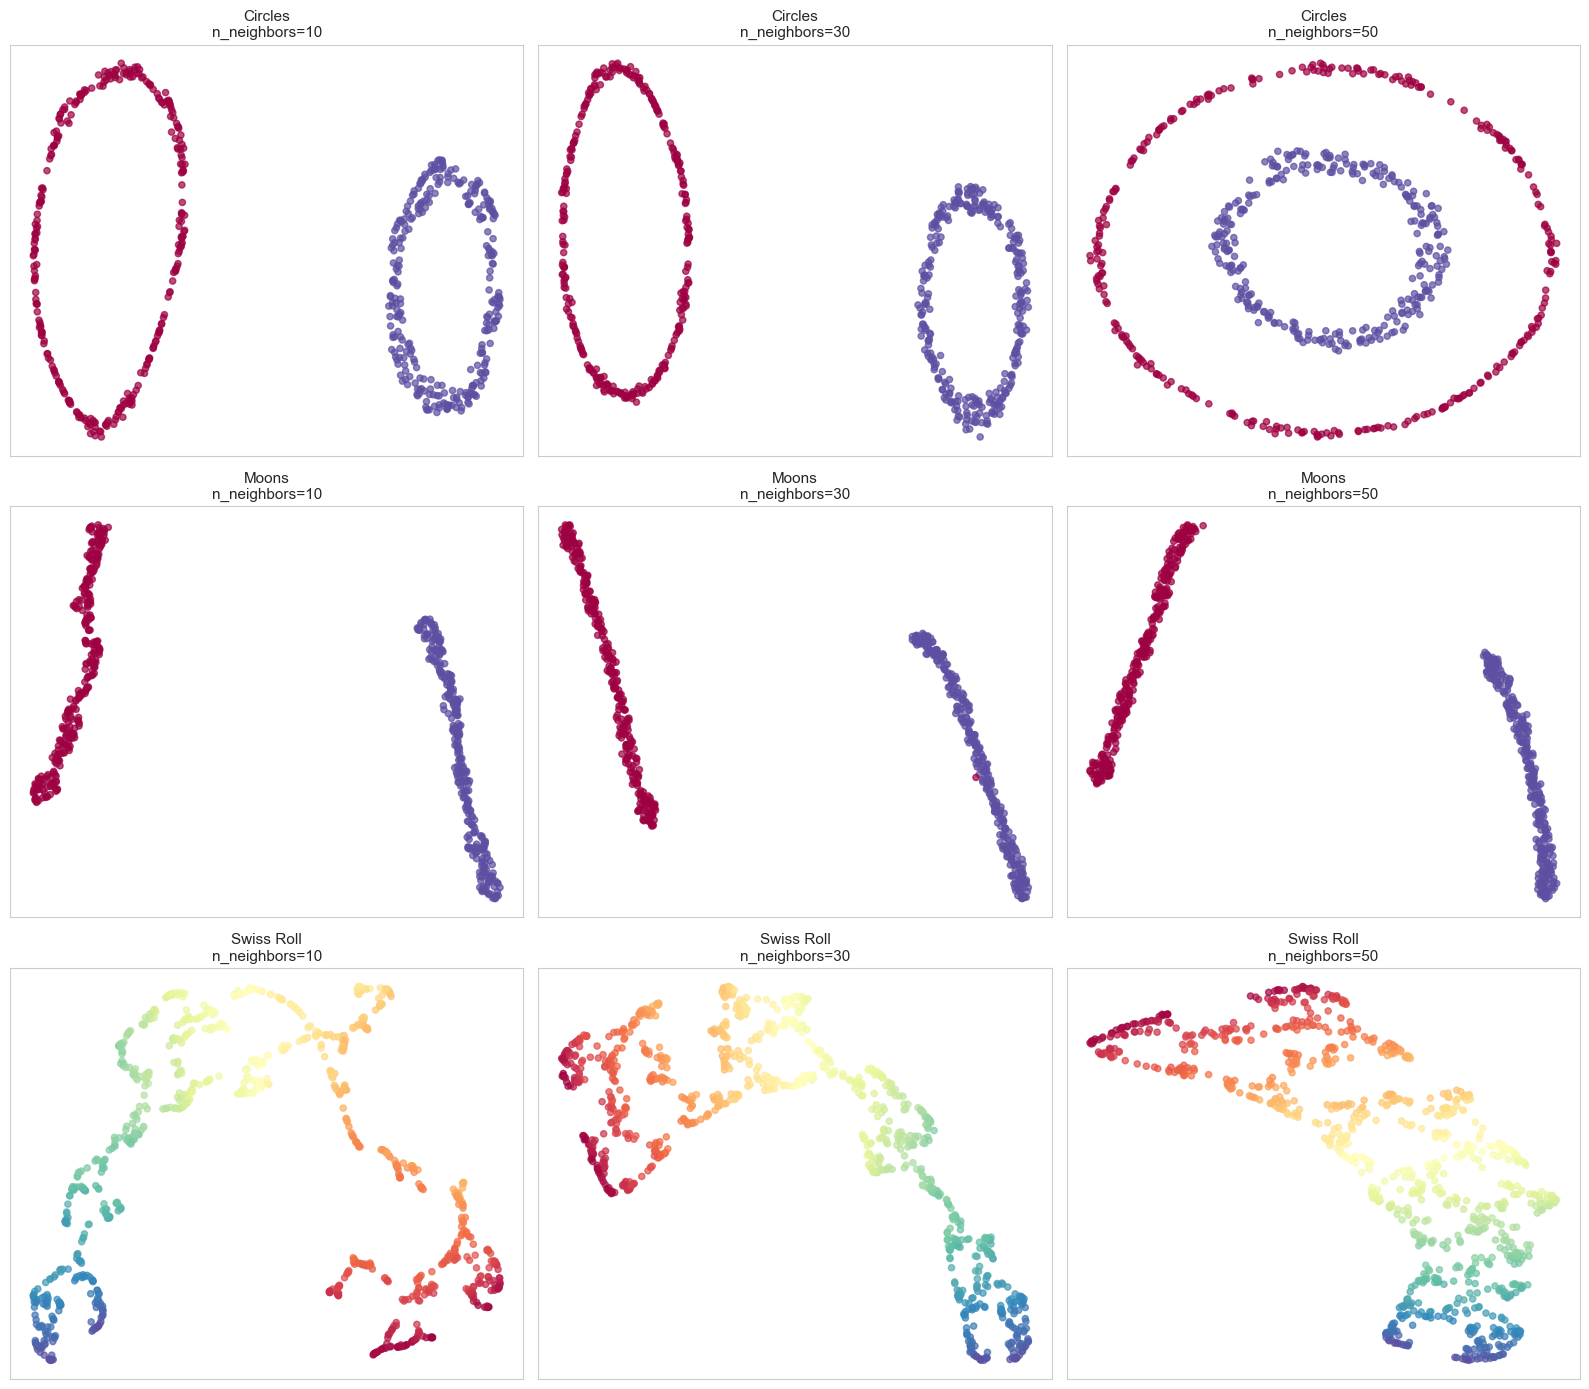

In [18]:
# Apply UMAP with different parameters
n_neighbors_list = [10, 30, 50]
min_dists = [0.0, 0.5]
    
fig, axes = plt.subplots(len(datasets), len(n_neighbors_list), figsize=(16, 14))
    
for row, (X, y, name) in enumerate(datasets):
    for col, n_neigh in enumerate(n_neighbors_list):
        # Use mid min_dist for this demo
        min_d = 0.1
            
        # Reduce to 30D first for high-D data (swiss roll is only 3D, so skip PCA)
        if X.shape[1] > 30:
            X_pre = PCA(n_components=30, random_state=SEED).fit_transform(X)
        else:
            X_pre = X
            
        umap_model = umap.UMAP(n_neighbors=n_neigh, min_dist=min_d, random_state=SEED)
        X_umap = umap_model.fit_transform(X_pre)
            
        scatter = axes[row, col].scatter(X_umap[:, 0], X_umap[:, 1], 
                                            c=y, cmap='Spectral', s=20, alpha=0.7)
        axes[row, col].set_title(f'{name}\nn_neighbors={n_neigh}', fontsize=11)
        axes[row, col].set_xticks([])
        axes[row, col].set_yticks([])
    
plt.tight_layout()
plt.show()

**Parameter effects:**
- **n_neighbors=10:** Emphasizes local structure (similar to t-SNE with low perplexity)
- **n_neighbors=50:** More global view, clusters may merge

**UMAP vs. t-SNE:**
- UMAP is faster (10-100× on large datasets)
- UMAP has parametric transform (can embed new data)
- UMAP preserves more global structure
- t-SNE often has tighter, more distinct clusters

---
# Section 4: Detailed Analysis — AI vs. Human Text (DAIGT)

Now we analyze the DAIGT dataset we loaded in Section 0 from multiple angles. We'll visualize by prompt, label, model, and text length to understand what embeddings reveal about AI-generated vs. human text.

**Data already loaded:** We'll use `df_daigt_full` which contains ~7500 texts with embeddings, PCA projections, and t-SNE coordinates.

In [19]:
# Use the dataset from Section 0
df = df_daigt_full.copy()
X = np.vstack(df['embedding'].values)
y = df['label'].values

print(f"Analyzing {len(df):,} texts with embeddings")
print(f"  Shape: {X.shape}")
print(f"  Labels: {len(y)} (Human: {(y==0).sum():,}, AI: {(y==1).sum():,})")
print(f"  Prompts: {df['prompt_name'].nunique()}")
print(f"  Models: {df['model'].nunique()}")

Analyzing 15,000 texts with embeddings
  Shape: (15000, 384)
  Labels: 15000 (Human: 7,299, AI: 7,701)
  Prompts: 15
  Models: 13


## 4.1 Multi-Perspective Visualizations

### Visualization 1: Color by Prompt

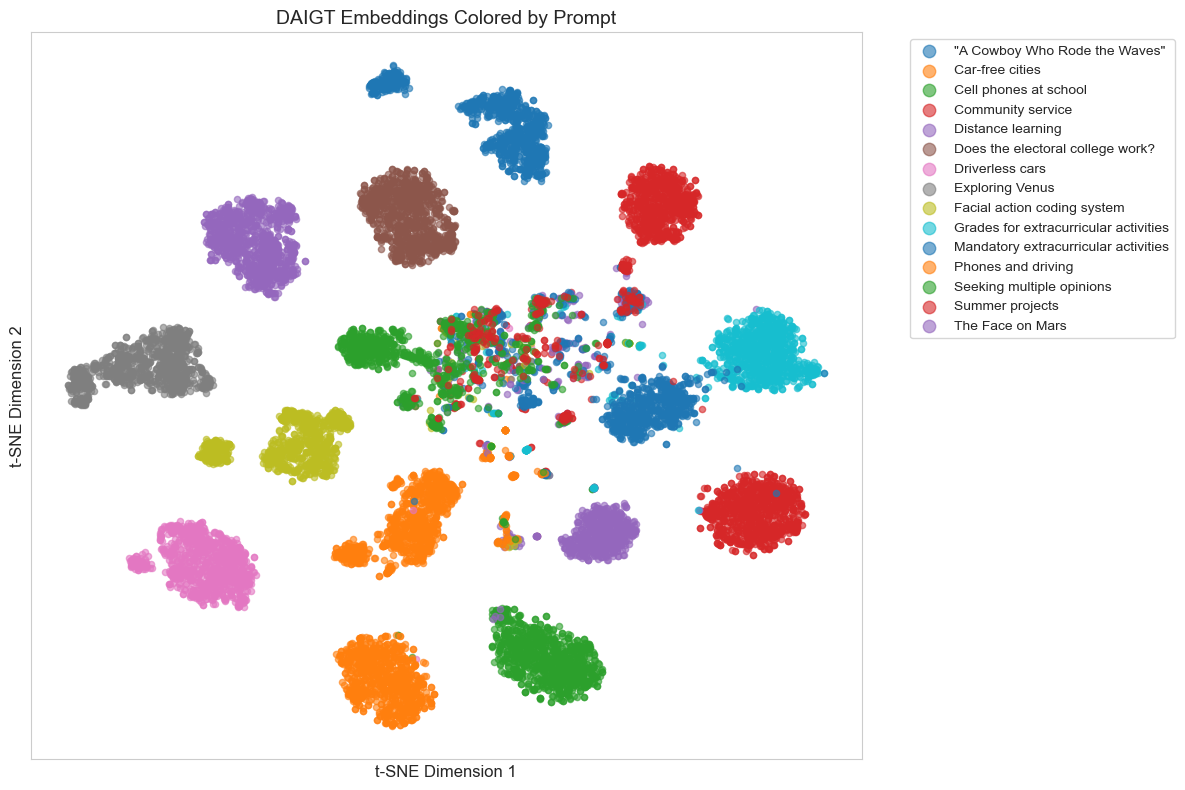

In [20]:
# Key Design Point 10: Prompt-Based Clustering
# Each essay prompt has different topic/content, so we expect natural clustering
# This helps us verify that embeddings capture semantic content
fig, ax = plt.subplots(figsize=(12, 8))

for prompt in df['prompt_name'].unique():
    mask = df['prompt_name'] == prompt
    ax.scatter(df[mask]['tsne_1'], df[mask]['tsne_2'], 
              label=prompt, alpha=0.6, s=20)

ax.set_xlabel('t-SNE Dimension 1', fontsize=12)
ax.set_ylabel('t-SNE Dimension 2', fontsize=12)
ax.set_title('DAIGT Embeddings Colored by Prompt', fontsize=14)
ax.legend(markerscale=2, bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_xticks([])
ax.set_yticks([])
plt.tight_layout()
plt.show()

**What to look for:**

Each "island" represents a different prompt. Clear separation means the embedder captures thematic differences between prompts. Prompts about similar topics (e.g., "Cell Phones at School" vs. "Phones and Driving") might appear closer together.

The clustering by prompt is expected—texts responding to different questions naturally use different vocabulary and concepts. This is **content-based clustering**, not yet about AI vs. human.

### Visualization 2: Color by Label (AI vs. Human)

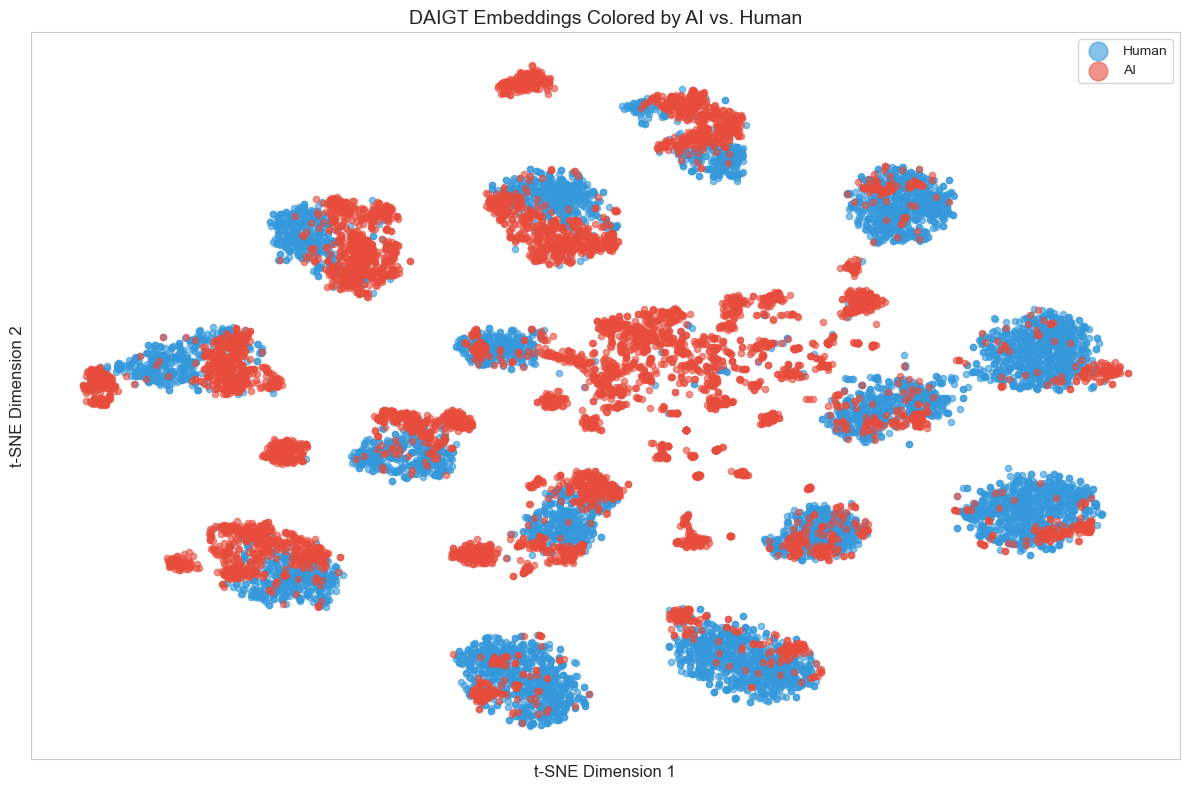

In [21]:
fig, ax = plt.subplots(figsize=(12, 8))

colors_label = {0: '#3498db', 1: '#e74c3c'}  # blue=human, red=AI
labels_map = {0: 'Human', 1: 'AI'}

for label_val in [0, 1]:
    mask = df['label'] == label_val
    ax.scatter(df[mask]['tsne_1'], df[mask]['tsne_2'], 
              c=colors_label[label_val], label=labels_map[label_val], 
              alpha=0.6, s=20)

ax.set_xlabel('t-SNE Dimension 1', fontsize=12)
ax.set_ylabel('t-SNE Dimension 2', fontsize=12)
ax.set_title('DAIGT Embeddings Colored by AI vs. Human', fontsize=14)
ax.legend(markerscale=3)
ax.set_xticks([])
ax.set_yticks([])
plt.tight_layout()
plt.show()

**Key observations:**

Within each prompt-island, do you see separation between AI (red) and human (blue) points? If AI and human texts cluster separately, embeddings are capturing stylistic differences beyond just topic.

Heavily mixed regions suggest some prompts produce similar AI/human writing, making detection harder. This tells us detection difficulty varies by prompt.

### Visualization 3: Color by Model Family

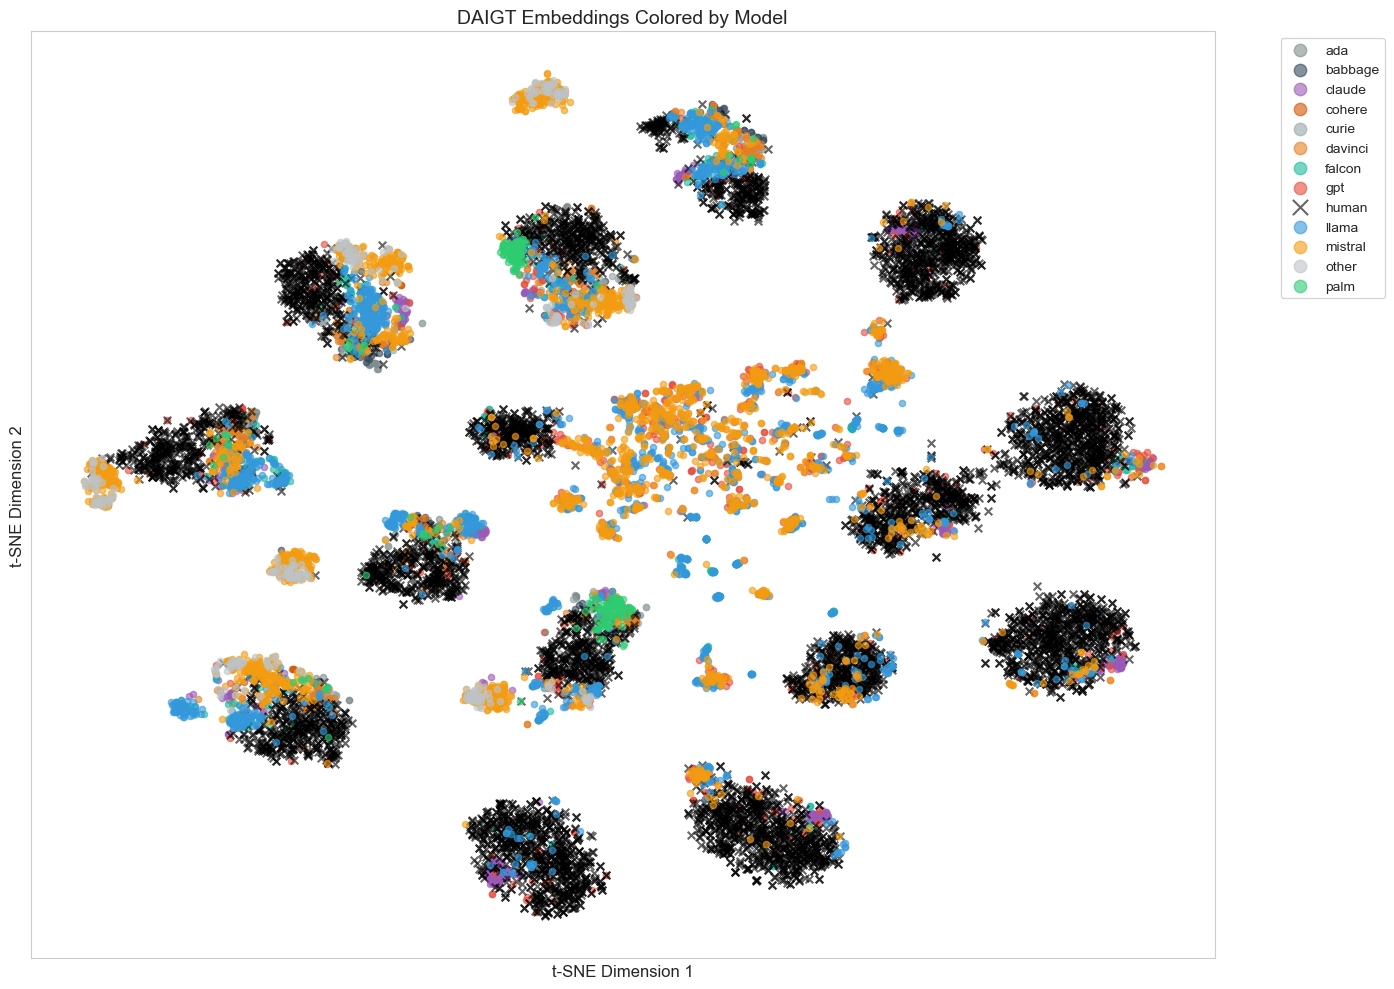

In [22]:
fig, ax = plt.subplots(figsize=(14, 10))

# Color mapping for real models in the dataset
model_colors = {
    'human': 'black',
    'gpt': '#e74c3c',        # red
    'claude': '#9b59b6',     # purple
    'llama': '#3498db',      # blue
    'palm': '#2ecc71',       # green
    'mistral': '#f39c12',    # orange
    'falcon': '#1abc9c',     # turquoise
    'davinci': '#e67e22',    # dark orange
    'curie': '#95a5a6',      # gray
    'babbage': '#34495e',    # dark gray
    'ada': '#7f8c8d',        # light gray
    'cohere': '#d35400',     # burnt orange
    'other': '#bdc3c7'       # light gray
}

for model in sorted(df['model'].unique()):
    mask = df['model'] == model
    marker = 'x' if model == 'human' else 'o'
    size = 30 if model == 'human' else 20
    ax.scatter(df[mask]['tsne_1'], df[mask]['tsne_2'], 
              c=model_colors.get(model, 'gray'), 
              label=model, marker=marker, s=size, alpha=0.6)

ax.set_xlabel('t-SNE Dimension 1', fontsize=12)
ax.set_ylabel('t-SNE Dimension 2', fontsize=12)
ax.set_title('DAIGT Embeddings Colored by Model', fontsize=14)
ax.legend(markerscale=2, bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_xticks([])
ax.set_yticks([])
plt.tight_layout()
plt.show()

**What this reveals:**

Different AI models cluster within their prompt-islands, showing each model has distinctive signatures. GPT-family models might cluster tightly (consistent style), while older models like Palm might be more scattered.

This suggests embeddings encode not just "AI vs. human" but specific model characteristics—vocabulary preferences, sentence structures, common phrases.

**Implication for detection:** A classifier trained on GPT-3 text might not generalize well to Claude or Llama text. The AI detection problem is not binary (AI/human) but multi-class (human/GPT-3/GPT-4/Claude/...).

### Visualization 4: Color by Word Count

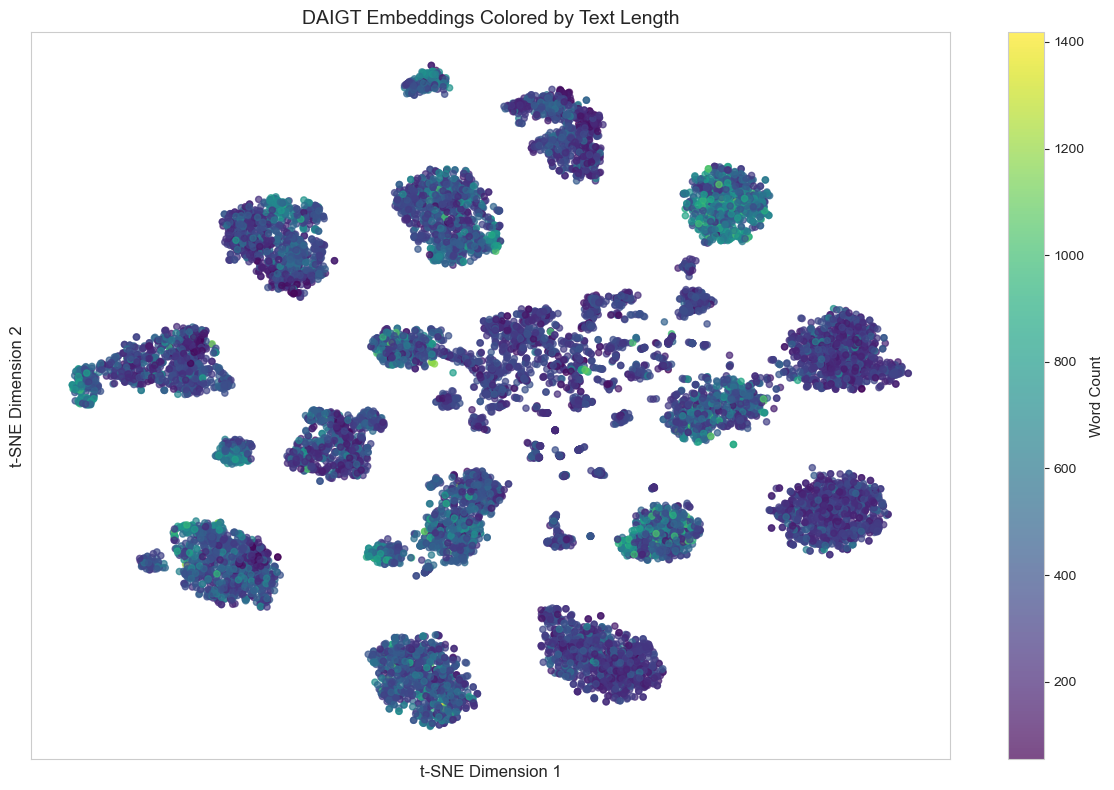


Mean word count by label:
label
0    400.100699
1    363.385924
Name: word_count, dtype: float64


In [23]:
fig, ax = plt.subplots(figsize=(12, 8))

scatter = ax.scatter(df['tsne_1'], df['tsne_2'], 
                    c=df['word_count'], cmap='viridis', s=20, alpha=0.7)
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Word Count', fontsize=11)

ax.set_xlabel('t-SNE Dimension 1', fontsize=12)
ax.set_ylabel('t-SNE Dimension 2', fontsize=12)
ax.set_title('DAIGT Embeddings Colored by Text Length', fontsize=14)
ax.set_xticks([])
ax.set_yticks([])
plt.tight_layout()
plt.show()

# Check correlation between label and length
print(f"\nMean word count by label:")
print(df.groupby('label')['word_count'].mean())

**⚠️ Warning sign: Text length leakage**

The gradient shows embeddings partially encode text length—longer texts appear in certain regions of the space. If you see a clear viridis gradient following the cluster structure, that's a red flag.

**Why this matters for AI detection:** If AI-generated text is systematically longer or shorter than human text for a given prompt, a classifier might "cheat" by learning length patterns rather than true stylistic differences.

**Best practice:** Always check if your target variable (AI/human) correlates with text length. Choose prompts with similar length distributions for fairer analysis. This is why the Medium author carefully selected the "Does the electoral college work?" prompt in the next section.

## 4.2 Prompt-Level View: "Does the electoral college work?"

Let's zoom into a single prompt where length distributions are more balanced, following the Medium blog's approach.

Selected prompt: 'Does the electoral college work?'
Number of samples: 1000

Label distribution:
label
1    607
0    393
Name: count, dtype: int64

Length statistics by label:
       count        mean         std    min    25%    50%    75%     max
label                                                                   
0      393.0  423.048346  166.313465  146.0  300.0  409.0  507.0  1174.0
1      607.0  423.924217  154.399820   70.0  316.0  394.0  507.0  1036.0


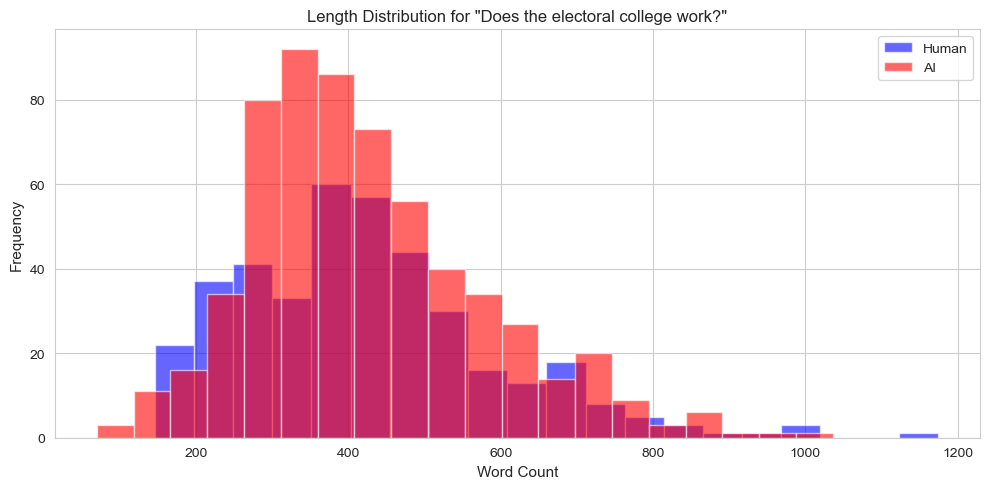

In [24]:
# Key Design Point 11: Single-Prompt Analysis for Length Control
# Different prompts may have different length biases between AI and human
# By focusing on one prompt, we can choose one with balanced distributions
selected_prompt = 'Does the electoral college work?'
df_prompt = df[df['prompt_name'] == selected_prompt].copy()

print(f"Selected prompt: '{selected_prompt}'")
print(f"Number of samples: {len(df_prompt)}")
print(f"\nLabel distribution:")
print(df_prompt['label'].value_counts())
print(f"\nLength statistics by label:")
print(df_prompt.groupby('label')['word_count'].describe())

# Visualize length distributions to check for bias
human_lengths = df_prompt[df_prompt['label']==0]['word_count']
ai_lengths = df_prompt[df_prompt['label']==1]['word_count']

fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(human_lengths, bins=20, alpha=0.6, label='Human', color='blue')
ax.hist(ai_lengths, bins=20, alpha=0.6, label='AI', color='red')
ax.set_xlabel('Word Count', fontsize=11)
ax.set_ylabel('Frequency', fontsize=11)
ax.set_title(f'Length Distribution for "{selected_prompt}"', fontsize=12)
ax.legend()
plt.tight_layout()
plt.show()

**Why this prompt?**

The Medium author chose this prompt because AI and human responses have comparable length distributions, reducing the risk of length-based shortcuts. This lets us focus on genuine stylistic differences.

Using 30 PCA components for this subset
Using perplexity=50 for t-SNE


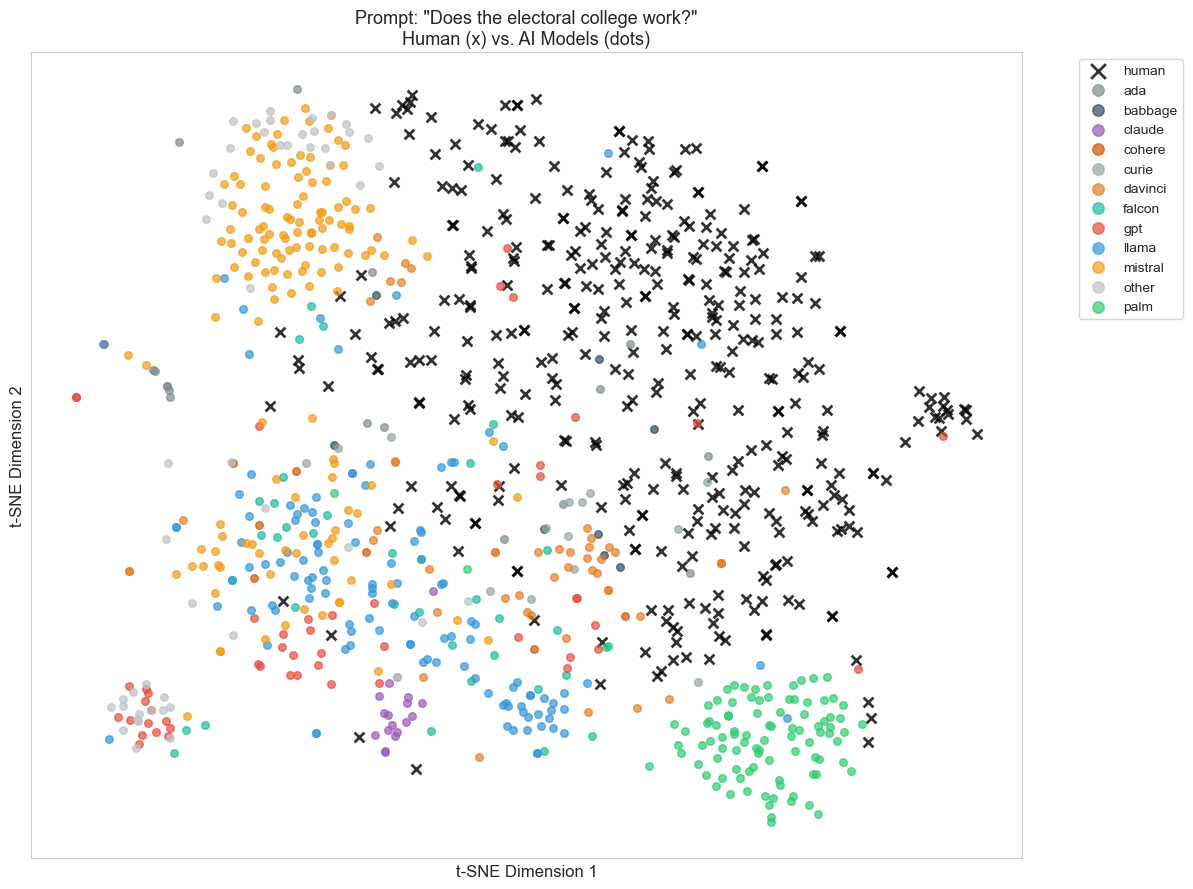

In [25]:
# Key Design Point 12: Recompute DR for Subset
# When focusing on a subset, recomputing PCA and t-SNE gives better resolution
# The full-dataset t-SNE might compress this prompt into one small region
X_prompt = np.vstack(df_prompt['embedding'].values)
y_prompt = df_prompt['label'].values

# Adapt parameters to subset size
# PCA: Keep min(30, n_samples-1, n_features) components
n_pca_components = min(30, len(df_prompt) - 1, X_prompt.shape[1])
print(f"Using {n_pca_components} PCA components for this subset")

X_prompt_pca = PCA(n_components=n_pca_components, random_state=SEED).fit_transform(X_prompt)

# t-SNE perplexity: Rule of thumb is 5-50, scaled to dataset size
# For n samples, use roughly n/3 but capped at 50
perplexity = min(50, max(5, len(df_prompt) // 3))
print(f"Using perplexity={perplexity} for t-SNE")

X_prompt_tsne = TSNE(n_components=2, perplexity=perplexity, init='pca', 
                     random_state=SEED).fit_transform(X_prompt_pca)

df_prompt['tsne_1'] = X_prompt_tsne[:, 0]
df_prompt['tsne_2'] = X_prompt_tsne[:, 1]
df_prompt['pca_embedding_prompt'] = list(X_prompt_pca)

# Visualize: humans as 'x', AI models as colored dots
fig, ax = plt.subplots(figsize=(12, 9))

# Humans first (black x)
mask_human = df_prompt['model'] == 'human'
ax.scatter(df_prompt[mask_human]['tsne_1'], df_prompt[mask_human]['tsne_2'], 
          c='black', marker='x', s=50, linewidths=2, label='human', alpha=0.8)

# AI models
for model in sorted([m for m in df_prompt['model'].unique() if m != 'human']):
    mask = df_prompt['model'] == model
    ax.scatter(df_prompt[mask]['tsne_1'], df_prompt[mask]['tsne_2'], 
              c=model_colors.get(model, 'gray'), marker='o', s=30, 
              label=model, alpha=0.7)

ax.set_xlabel('t-SNE Dimension 1', fontsize=12)
ax.set_ylabel('t-SNE Dimension 2', fontsize=12)
ax.set_title(f'Prompt: "{selected_prompt}"\nHuman (x) vs. AI Models (dots)', fontsize=13)
ax.legend(markerscale=1.5, bbox_to_anchor=(1.05, 1), loc='upper left')
ax.set_xticks([])
ax.set_yticks([])
plt.tight_layout()
plt.show()

**Reading this plot:**

- **Separated clusters:** If human 'x' marks cluster separately from AI dots, the embeddings successfully distinguish writing styles even within a single prompt.
- **Model diversity:** Different colored dots (different AI models) in different regions show that not all AI text is the same. GPT-4 might write differently than Llama-2.
- **Overlap zones:** Where 'x' marks mix with dots, human and AI writing are most similar. These are the hardest cases for detection.

**Takeaway:** Even with controlled length, embeddings capture signals beyond topic. But no method is perfect—there's always overlap.

## 4.3 Clustering on PCA Space (not on t-SNE!)

**Why cluster on PCA space?**

t-SNE distorts distances and inflates cluster sizes for visualization. PCA 30D preserves more faithful distance relationships, making clustering more meaningful. This is a critical methodological point from the Medium article.

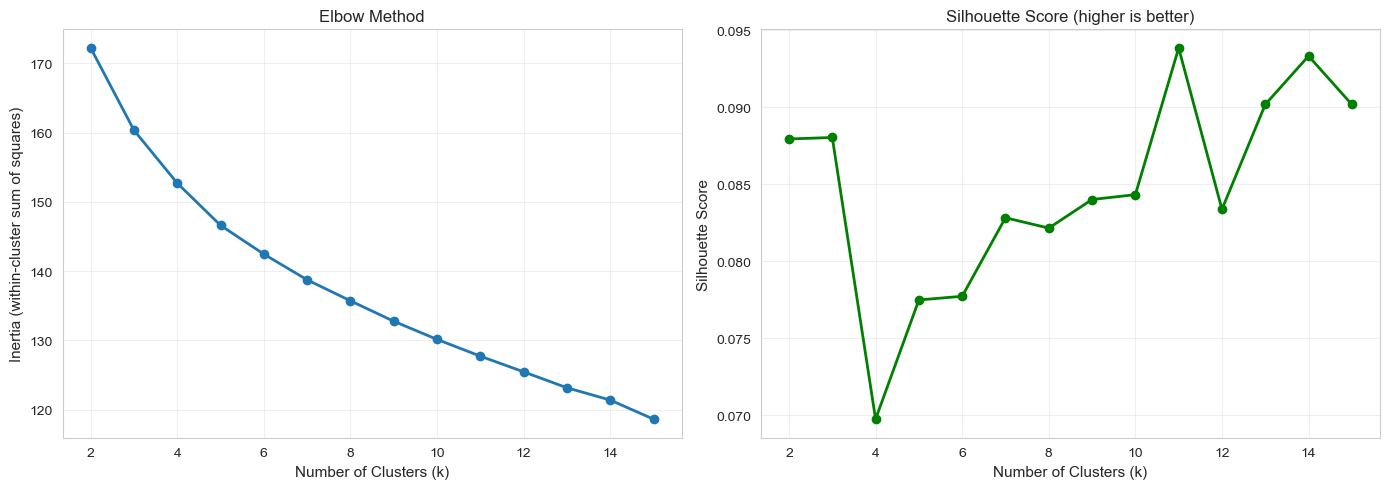


Optimal k by silhouette: 11


In [26]:
# Key Design Point 13: Cluster in PCA Space, Visualize in t-SNE Space
# t-SNE distorts distances (nearby points pulled together, far points pushed apart)
# For meaningful clustering, use the PCA representation which preserves distances better
# Then visualize the cluster assignments on t-SNE for interpretability

# Use PCA embeddings for clustering (not t-SNE!)
# Elbow method to find optimal number of clusters
ks = range(2, 16)
inertias = []
silhouettes = []

for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=SEED, n_init=10)
    kmeans.fit(X_prompt_pca)
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X_prompt_pca, kmeans.labels_))

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(ks, inertias, 'o-', linewidth=2)
axes[0].set_xlabel('Number of Clusters (k)', fontsize=11)
axes[0].set_ylabel('Inertia (within-cluster sum of squares)', fontsize=11)
axes[0].set_title('Elbow Method', fontsize=12)
axes[0].grid(True, alpha=0.3)

axes[1].plot(ks, silhouettes, 'o-', linewidth=2, color='green')
axes[1].set_xlabel('Number of Clusters (k)', fontsize=11)
axes[1].set_ylabel('Silhouette Score', fontsize=11)
axes[1].set_title('Silhouette Score (higher is better)', fontsize=12)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Pick k (e.g., where silhouette peaks or elbow appears)
k_opt = ks[np.argmax(silhouettes)]
print(f"\nOptimal k by silhouette: {k_opt}")


Cluster vs. Label Crosstab:
Cluster   0   1   2   3   4   5   6    7   8   9    10
Human      4  67  68  16   5  15   3  120   3  84    8
AI       176   7   8  68  99  55  37    9  12   5  131


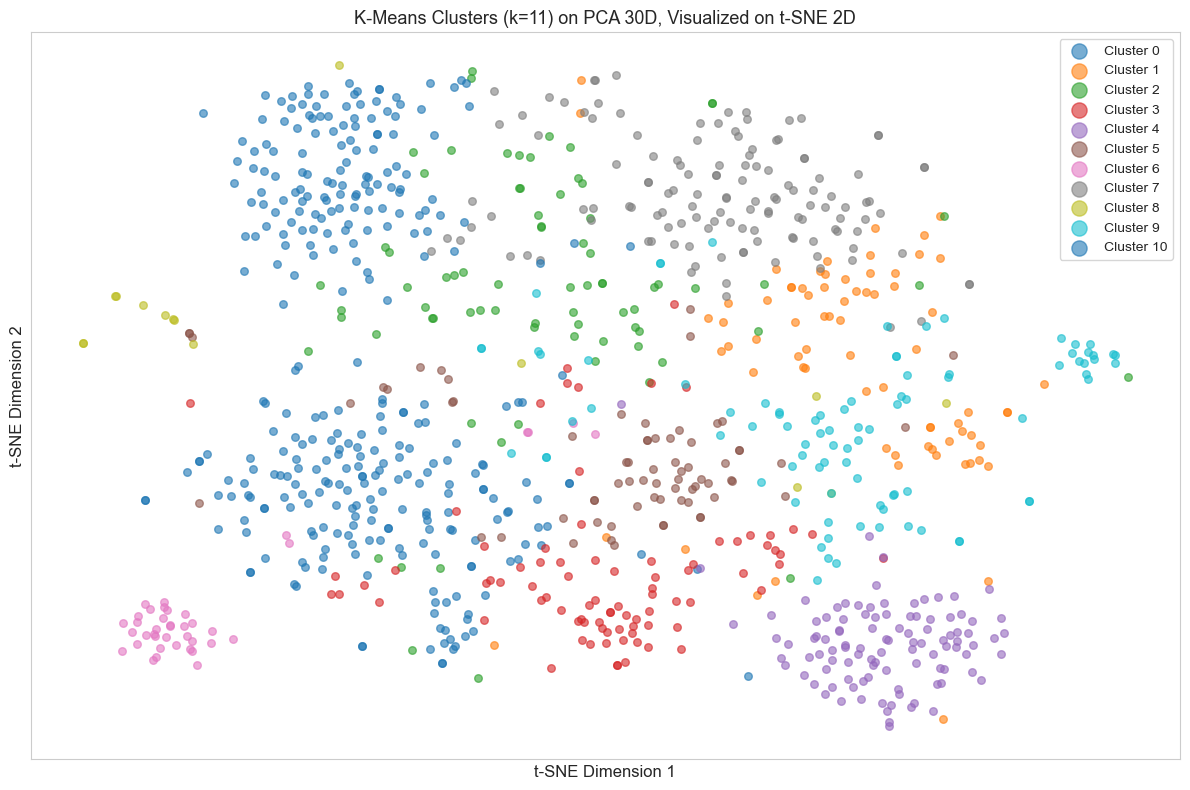

In [27]:
# Fit final clustering
kmeans_final = KMeans(n_clusters=k_opt, random_state=SEED, n_init=10)
df_prompt['cluster'] = kmeans_final.fit_predict(X_prompt_pca)

# Crosstab: clusters vs. labels
crosstab = pd.crosstab(df_prompt['label'], df_prompt['cluster'], 
                       rownames=['Label'], colnames=['Cluster'])
crosstab.index = ['Human', 'AI']

print("\nCluster vs. Label Crosstab:")
print(crosstab)

# Visualize clusters on t-SNE
fig, ax = plt.subplots(figsize=(12, 8))

for cluster in range(k_opt):
    mask = df_prompt['cluster'] == cluster
    ax.scatter(df_prompt[mask]['tsne_1'], df_prompt[mask]['tsne_2'], 
              label=f'Cluster {cluster}', alpha=0.6, s=30)

ax.set_xlabel('t-SNE Dimension 1', fontsize=12)
ax.set_ylabel('t-SNE Dimension 2', fontsize=12)
ax.set_title(f'K-Means Clusters (k={k_opt}) on PCA 30D, Visualized on t-SNE 2D', fontsize=13)
ax.legend(markerscale=2)
ax.set_xticks([])
ax.set_yticks([])
plt.tight_layout()
plt.show()

**Reading the crosstab:**

- **High-purity clusters** (>80% AI or >80% human) suggest distinct writing patterns. A cluster with 95% AI might capture a specific model signature.
- **Mixed clusters** (40-60% AI/human) represent prompts or styles where AI and human writing overlap significantly.
- **Cluster sizes:** Large mixed clusters indicate substantial ambiguity—many texts are hard to classify even for embeddings + clustering.

**For detection:** High-purity clusters are promising, but mixed clusters remind us that no feature set perfectly separates all AI from all human text. The problem is inherently noisy.

---
# Conclusion

Dimensionality reduction is both art and science. PCA provides the foundation—fast, interpretable, and preserving global structure. But real data often requires nonlinear methods to reveal hidden clusters and local patterns.

**Key insights:**
1. **No method is perfect:** PCA is linear, t-SNE distorts global structure, UMAP can be sensitive to parameters
2. **Use multiple methods:** If a pattern appears consistently, it's more trustworthy
3. **Understand trade-offs:** Local vs. global, speed vs. quality, deterministic vs. stochastic
4. **Preprocess wisely:** PCA before t-SNE/UMAP saves time and improves results
5. **Validate quantitatively:** Visualizations are beautiful but can mislead

**For AI text detection:**
- Embeddings capture both content (prompt) and style (AI vs. human, model signatures)
- Text length leakage is a real concern—always check
- Model diversity means detection is multi-class, not binary
- No feature set perfectly separates all AI from all human text

**Moving forward:**
- Experiment with these methods on your own data
- Check the mammoth test to validate global structure
- Try the rainbow test for continuous structures
- Always cluster in higher-D space, visualize in 2D

Dimensionality reduction opens a window into high-dimensional spaces. Use it wisely, validate thoroughly, and remember: the map is not the territory, but it can guide you to insights.

## References and Resources

**PCA:**
- Sklearn documentation: https://scikit-learn.org/stable/modules/decomposition.html#pca
- Jolliffe, I. T. (2002). Principal Component Analysis (2nd ed.)

**t-SNE:**
- van der Maaten & Hinton (2008). "Visualizing Data using t-SNE" JMLR
- Distill.pub article: https://distill.pub/2016/misread-tsne/

**UMAP:**
- McInnes et al. (2018). "UMAP: Uniform Manifold Approximation and Projection"
- Documentation: https://umap-learn.readthedocs.io/

**PaCMAP:**
- Wang et al. (2021). "Understanding How Dimension Reduction Tools Work" JMLR
- GitHub: https://github.com/YingfanWang/PaCMAP

**DAIGT Dataset:**
- Medium article (Part 1): Yang Lu, "Visualizing AI vs Human writing embeddings using TSNE"
- Medium article (Part 2): "AI Detection in Similar Texts"
- Kaggle: DAIGT V3 Train Dataset

**Mammoth Dataset:**
- Included in Lecture 12 directory as mammoth_data.csv
- Source: PaCMAP repository https://github.com/YingfanWang/PaCMAP/tree/master/demo
- Alternative: https://github.com/MNoichl/UMAP-examples-mammoth-
- Original: Smithsonian 3D Digitization https://3d.si.edu/